<font size="5">ONLINE ANALYSIS FOR CLOSED LOOP EXPERIMENTS </font>

    --> input: caiman online analysis output, .mat file with experimental trialwise info
    --> output: some plots and arrays with xy coordinates of cells with interesting properties to use as targets            

In [1]:
import os
os.chdir('C://Users//Scanimage//Desktop//GitHub Code Mori//caiman_online')
print(os.getcwd())

import bokeh.plotting as bpl
import cv2
import logging
try:
    cv2.setNumThreads(0)
except():
    pass

import sys
import json
from glob import glob
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ScanImageTiffReader import ScanImageTiffReader

import caiman as cm
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf import params as params

from caiman_analysis import *
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour, view_patches_bar, view_patches
bpl.output_notebook()
%config InlineBackend.figure_format = 'retina'
import scipy.stats as stats
from vis import *
from scipy.io import savemat


C:\Users\Scanimage\Desktop\GitHub Code Mori\caiman_online


C:\Users\Scanimage\anaconda3\envs\caiman\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Scanimage\anaconda3\envs\caiman\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Scanimage\anaconda3\envs\caiman\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Scanimage\anaconda3\envs\caiman\lib\site-packages

Loading BokehJS ...

<font size="3">Some info about where the files are and how the FOV was cropped </font>

    --> caiman output normally lives in a subfolder "/out/" inside the tiffs folder

In [2]:
user_name = 'Mora'
#is your FOV cropped? if yes, please enter 
x_start = 100 # if not cropped this is 0
x_end = 450 # if not cropped this is 512
date = '20200802'
mouse = 'MBOT5_419'
exp_name = 'ori'

tif_folder = 'D://'+ user_name + '//' + date +'//' + mouse + '//' + exp_name + '//'
#tif_folder='F://Experiments//EMX-triples//20200706//MBOT4_212//FOV2//noise//'
out_path = tif_folder + '//' + 'out//'

js = glob(out_path + '*.json')[-1]
hs = glob(out_path + '*.hdf5')[-1]

cnm = load_as_obj(hs)
jason= load_json(js)

In [3]:
# If the files have different sizes (eg if you're doing a stim test)
get_file_sizes = True
if get_file_sizes:
    files_sizes = cm.source_extraction.cnmf.utilities.get_file_size(glob(tif_folder+'*.tif'))
    


In [4]:
cnm.estimates.detrend_df_f(quantileMin=8, frames_window=250)

In [5]:
cnm.estimates.F_dff.shape

(389, 18000)

In [6]:

splits= ((np.asarray(files_sizes[1]))/2).astype(int)
traces = process_data(cnm.estimates.C, splits,normalizer='scale')

#alternative, build your splits with the trialLen and the numTrials
#trialLen=min(files_sizes[1])/2
#numTrials = 20
#splits=(np.ones(numTrials)*trialLen).astype(int) 


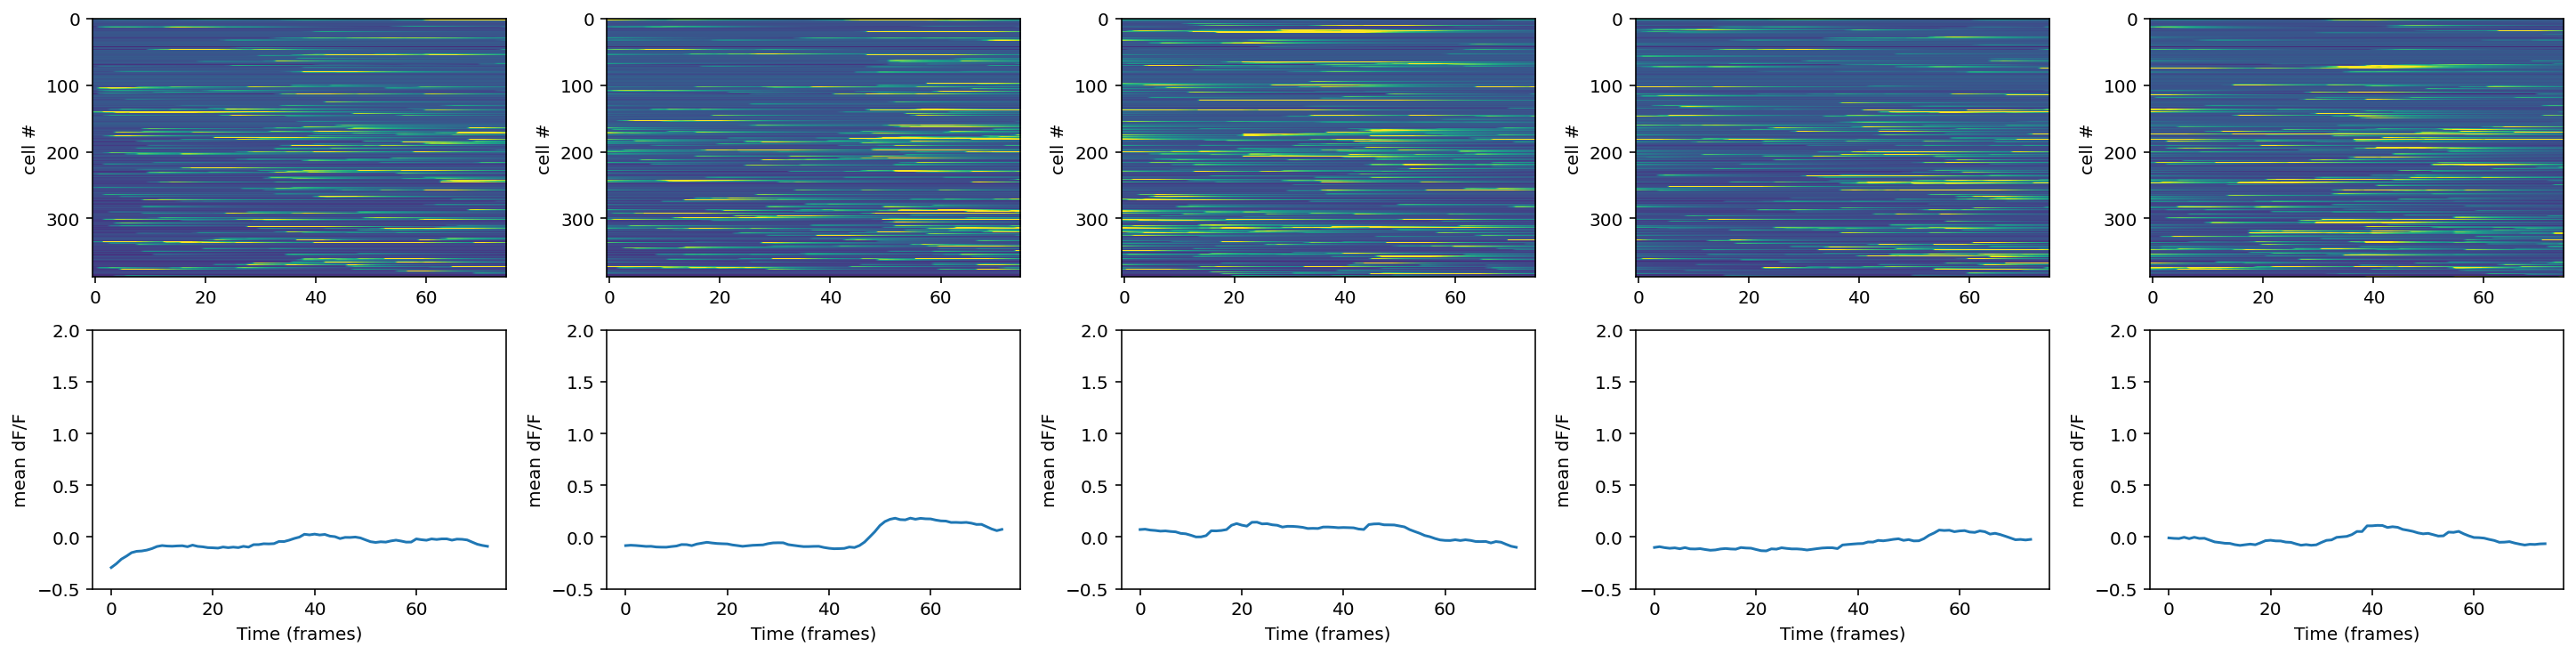

In [7]:
# need to fix the bottom plots, it was working before..
ncol=5
f, axes = plt.subplots(2,ncol, figsize=(4*ncol,ncol), constrained_layout=True)
axes = axes.ravel()

for i,ax in enumerate(axes[0:5]):
    ax.set_ylabel('cell #')
    ax.imshow(traces[i,:,:], aspect='auto', vmin=-1, vmax=2)
    #f.colorbar()

for i,ax in enumerate(axes[5:11]):
    ax.plot(np.mean(traces[i,:,:],axis =0))
    ax.set_ylim(-0.5,2)
    ax.set_ylabel('mean dF/F')
    ax.set_xlabel('Time (frames)')

 """
    Make the data frame for the analysis. Needs traces (cell x trials x time),
    a trialwise list of visIDs/orientations and the framerate of acq to get
    time in seconds.

    Inputs:
        traces (array): cells x trials x time
        vis_stim (array): trialwise list of vis stims (ori, contrast, etc.) shown

In [8]:
import scipy.io as sio
from vis import create_df
import h5py

daq_path = 'Z://frankenshare//Mora//visStim_Data//20200802//ori_MBOT5_419_20200802.mat'
daq_path = glob(daq_path)[0]

#if your matlab file is old use use sio.loadmat, otherwise use h5py.File
# mat1 = sio.loadmat(daq_path) 
# mat1.keys()

mat1 = h5py.File(daq_path)
mat1.keys()

C:\Users\Scanimage\anaconda3\envs\caiman\lib\site-packages\ipykernel_launcher.py:12: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  if sys.path[0] == '':


<KeysViewHDF5 ['IEpStart', 'acqTime', 'input', 'numbEp', 'output', 'sampFreq', 'sampleTime', 'shuffleStims', 'stimConds']>

In [9]:
daq_path

'Z://frankenshare//Mora//visStim_Data//20200802//ori_MBOT5_419_20200802.mat'

In [10]:
traces.shape

(240, 389, 75)

In [11]:
#do ori pipeline only with cell 393 to verify everythin, should have a very high OSI

<font size="5">PIPELINE FOR ORIENTATION SELECTIVITY</font>

In [12]:
#for ORIENTATION SELECTIVITY EXPERIMENTS
vis_id = tuple(np.squeeze(np.array(mat1['stimConds'][:,2].astype('int'))))
vis_oris =  tuple(np.squeeze(np.array(mat1['shuffleStims'][:].astype('int'))))#[0:numTrials]
#for STIM TEST EXPERIMENTS
#------------- TO DO -------------#

In [13]:
vis_oris

(10,
 5,
 1,
 11,
 8,
 2,
 9,
 12,
 7,
 3,
 4,
 6,
 4,
 12,
 10,
 11,
 3,
 7,
 9,
 8,
 1,
 5,
 6,
 2,
 2,
 10,
 4,
 5,
 3,
 8,
 12,
 11,
 7,
 1,
 6,
 9,
 12,
 3,
 9,
 5,
 4,
 6,
 11,
 10,
 7,
 8,
 1,
 2,
 1,
 6,
 8,
 4,
 2,
 9,
 5,
 10,
 7,
 11,
 12,
 3,
 2,
 3,
 11,
 8,
 12,
 6,
 4,
 10,
 1,
 7,
 5,
 9,
 8,
 3,
 11,
 2,
 6,
 12,
 5,
 1,
 10,
 9,
 4,
 7,
 9,
 2,
 1,
 6,
 11,
 10,
 8,
 3,
 7,
 4,
 12,
 5,
 10,
 3,
 11,
 5,
 1,
 9,
 2,
 4,
 6,
 7,
 8,
 12,
 9,
 5,
 7,
 1,
 6,
 3,
 10,
 11,
 2,
 12,
 8,
 4,
 1,
 10,
 9,
 7,
 3,
 8,
 2,
 5,
 12,
 4,
 11,
 6,
 8,
 10,
 2,
 11,
 9,
 12,
 5,
 7,
 6,
 1,
 4,
 3,
 2,
 10,
 7,
 9,
 12,
 1,
 6,
 5,
 11,
 8,
 3,
 4,
 12,
 8,
 3,
 4,
 9,
 1,
 10,
 2,
 7,
 11,
 5,
 6,
 1,
 2,
 12,
 10,
 8,
 6,
 7,
 5,
 3,
 11,
 4,
 9,
 4,
 10,
 1,
 8,
 9,
 7,
 11,
 12,
 2,
 6,
 3,
 5,
 7,
 4,
 6,
 10,
 12,
 11,
 3,
 2,
 5,
 1,
 9,
 8,
 8,
 6,
 1,
 7,
 9,
 4,
 2,
 11,
 10,
 3,
 5,
 12,
 6,
 2,
 7,
 10,
 8,
 1,
 5,
 9,
 11,
 12,
 3,
 4,
 10,
 7,
 2,
 1,
 8,
 3,
 4,
 5

In [14]:
vis_oris_n = np.array(vis_oris)
for i, ori in enumerate(vis_id):
    vis_oris_n[vis_oris_n==(i+1)]=vis_id[i]
    vis_oris =tuple(vis_oris_n)

fr = 15

In [15]:
vis_df = create_df(traces, vis_stim=vis_oris, vis_name='ori', fr=fr)
win= (1.5,2,2.1,5) 
col_name = 'ori'
df, mean_df = run_pipeline(vis_df, win, col_name)

There are 49 visually responsive cells, out of 389 (12.60%)


<font size="5">plots</font>

(array([ 23., 146., 131.,  66.,  11.,   8.,   2.,   1.,   0.,   1.]),
 array([-0.00826291, -0.00219676,  0.00386939,  0.00993554,  0.01600169,
         0.02206783,  0.02813398,  0.03420013,  0.04026628,  0.04633243,
         0.05239858]),
 <a list of 10 Patch objects>)

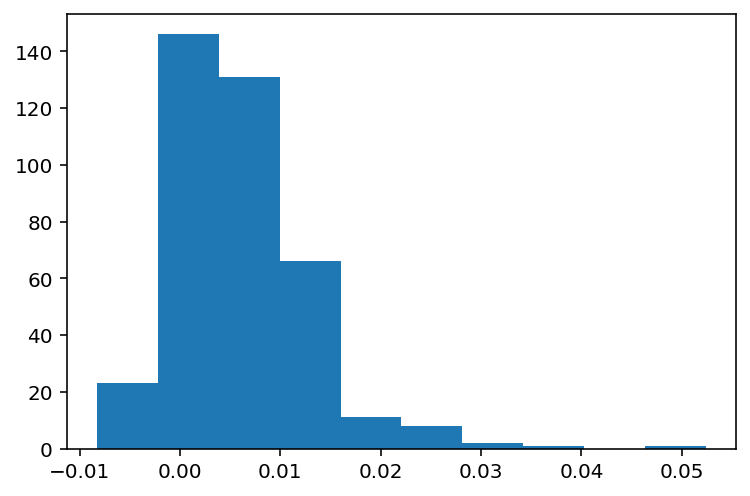

In [16]:
plt.hist(df.osi.unique())


In [17]:
#append the vis responsive list from mean_df to df 
cells = mean_df[mean_df.vis_resp ==True].cell.unique()
df.loc[:, 'vis_resp'] = False
df.loc[df.cell.isin(cells), 'vis_resp'] = True

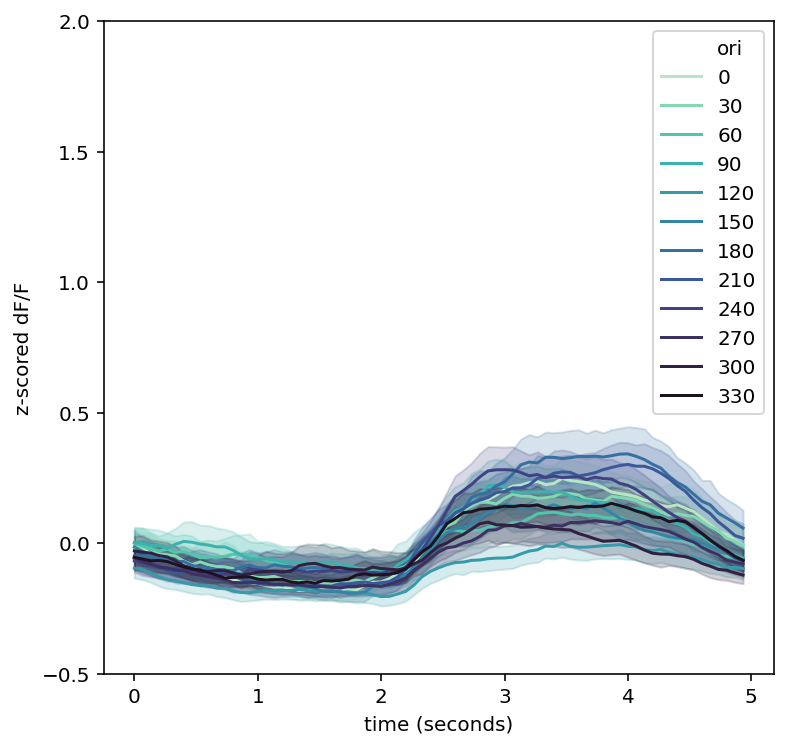

In [18]:
plt.figure(figsize=(6,6))
df['ori'] = df['ori'].astype('category') # this tells pandas that the variable ori is not a numerical but rather a cathegorical so it can be used as a real "hue" in the lineplots
data= df[df.vis_resp==True]# now wew can plot only vis responsive cells

#palette="ch:2.5,.25"
#plot contrast responses in visually responsive cells
palette = sns.color_palette("mako_r", len(vis_id))
sns.lineplot(x='time', y='df', hue='ori', data=data,palette=palette)
plt.xlabel('time (seconds)')
plt.ylabel('z-scored dF/F')
plt.ylim(-0.5,2)

plt.savefig(out_path + 'psths by ori Vis responsive')
plt.show()

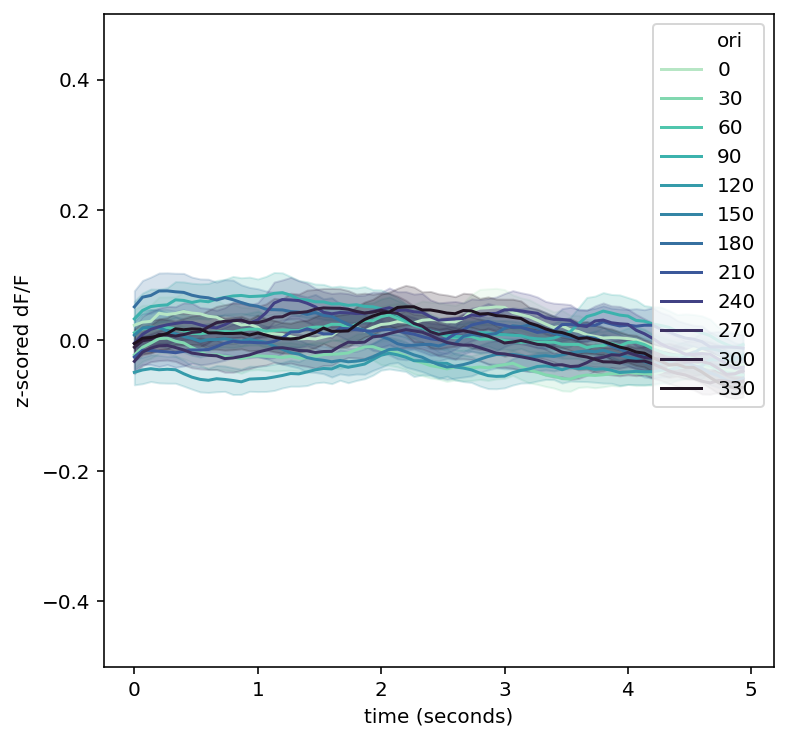

In [19]:
plt.figure(figsize=(6,6))
df['ori'] = df['ori'].astype('category') # this tells pandas that the variable ori is not a numerical but rather a cathegorical so it can be used as a real "hue" in the lineplots
data= df[df.vis_resp==False]# now wew can plot only NON vis responsive cells

#palette="ch:2.5,.25"
#plot contrast responses in visually responsive cells
palette = sns.color_palette("mako_r", len(vis_id))
sns.lineplot(x='time', y='df', hue='ori', data=data,palette=palette)
plt.xlabel('time (seconds)')
plt.ylabel('z-scored dF/F')
plt.ylim(-0.5,0.5)
plt.savefig(out_path + 'psths by ori NON Vis responsive')
plt.show()

In [20]:
df

,cell,trial,time,df,frame,ori,pref,ortho,pdir,osi,vis_resp
0,0,0,0,0.464001,0,270,0,90,60,0.015725,False
1,0,1,0,0.885132,0,120,0,90,60,0.015725,False
2,0,2,0,1.386325,0,0,0,90,60,0.015725,False
3,0,3,0,0.467272,0,300,0,90,60,0.015725,False
4,0,4,0,1.719434,0,210,0,90,60,0.015725,False
...,...,...,...,...,...,...,...,...,...,...,...
7001995,388,235,4.93333,-0.409861,74,120,30,120,330,-0.001362,False
7001996,388,236,4.93333,-0.360206,74,150,30,120,330,-0.001362,False
7001997,388,237,4.93333,-0.409840,74,330,30,120,330,-0.001362,False
7001998,388,238,4.93333,-0.395003,74,240,30,120,330,-0.001362,False


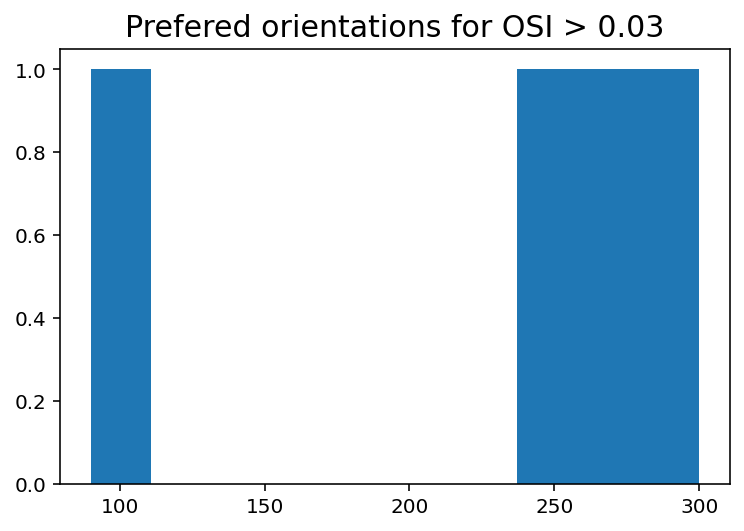

In [21]:
osi_filter = 0.03
pref_oris_selective = df[df.osi>osi_filter].set_index('pdir').groupby(['cell'])['df'].idxmax() # get the max/pref ori
plt.hist(pref_oris_selective)
plt.title('Prefered orientations for OSI > '+str(osi_filter), fontsize = 15)
plt.savefig(out_path + 'pref oris histogram')
plt.show()

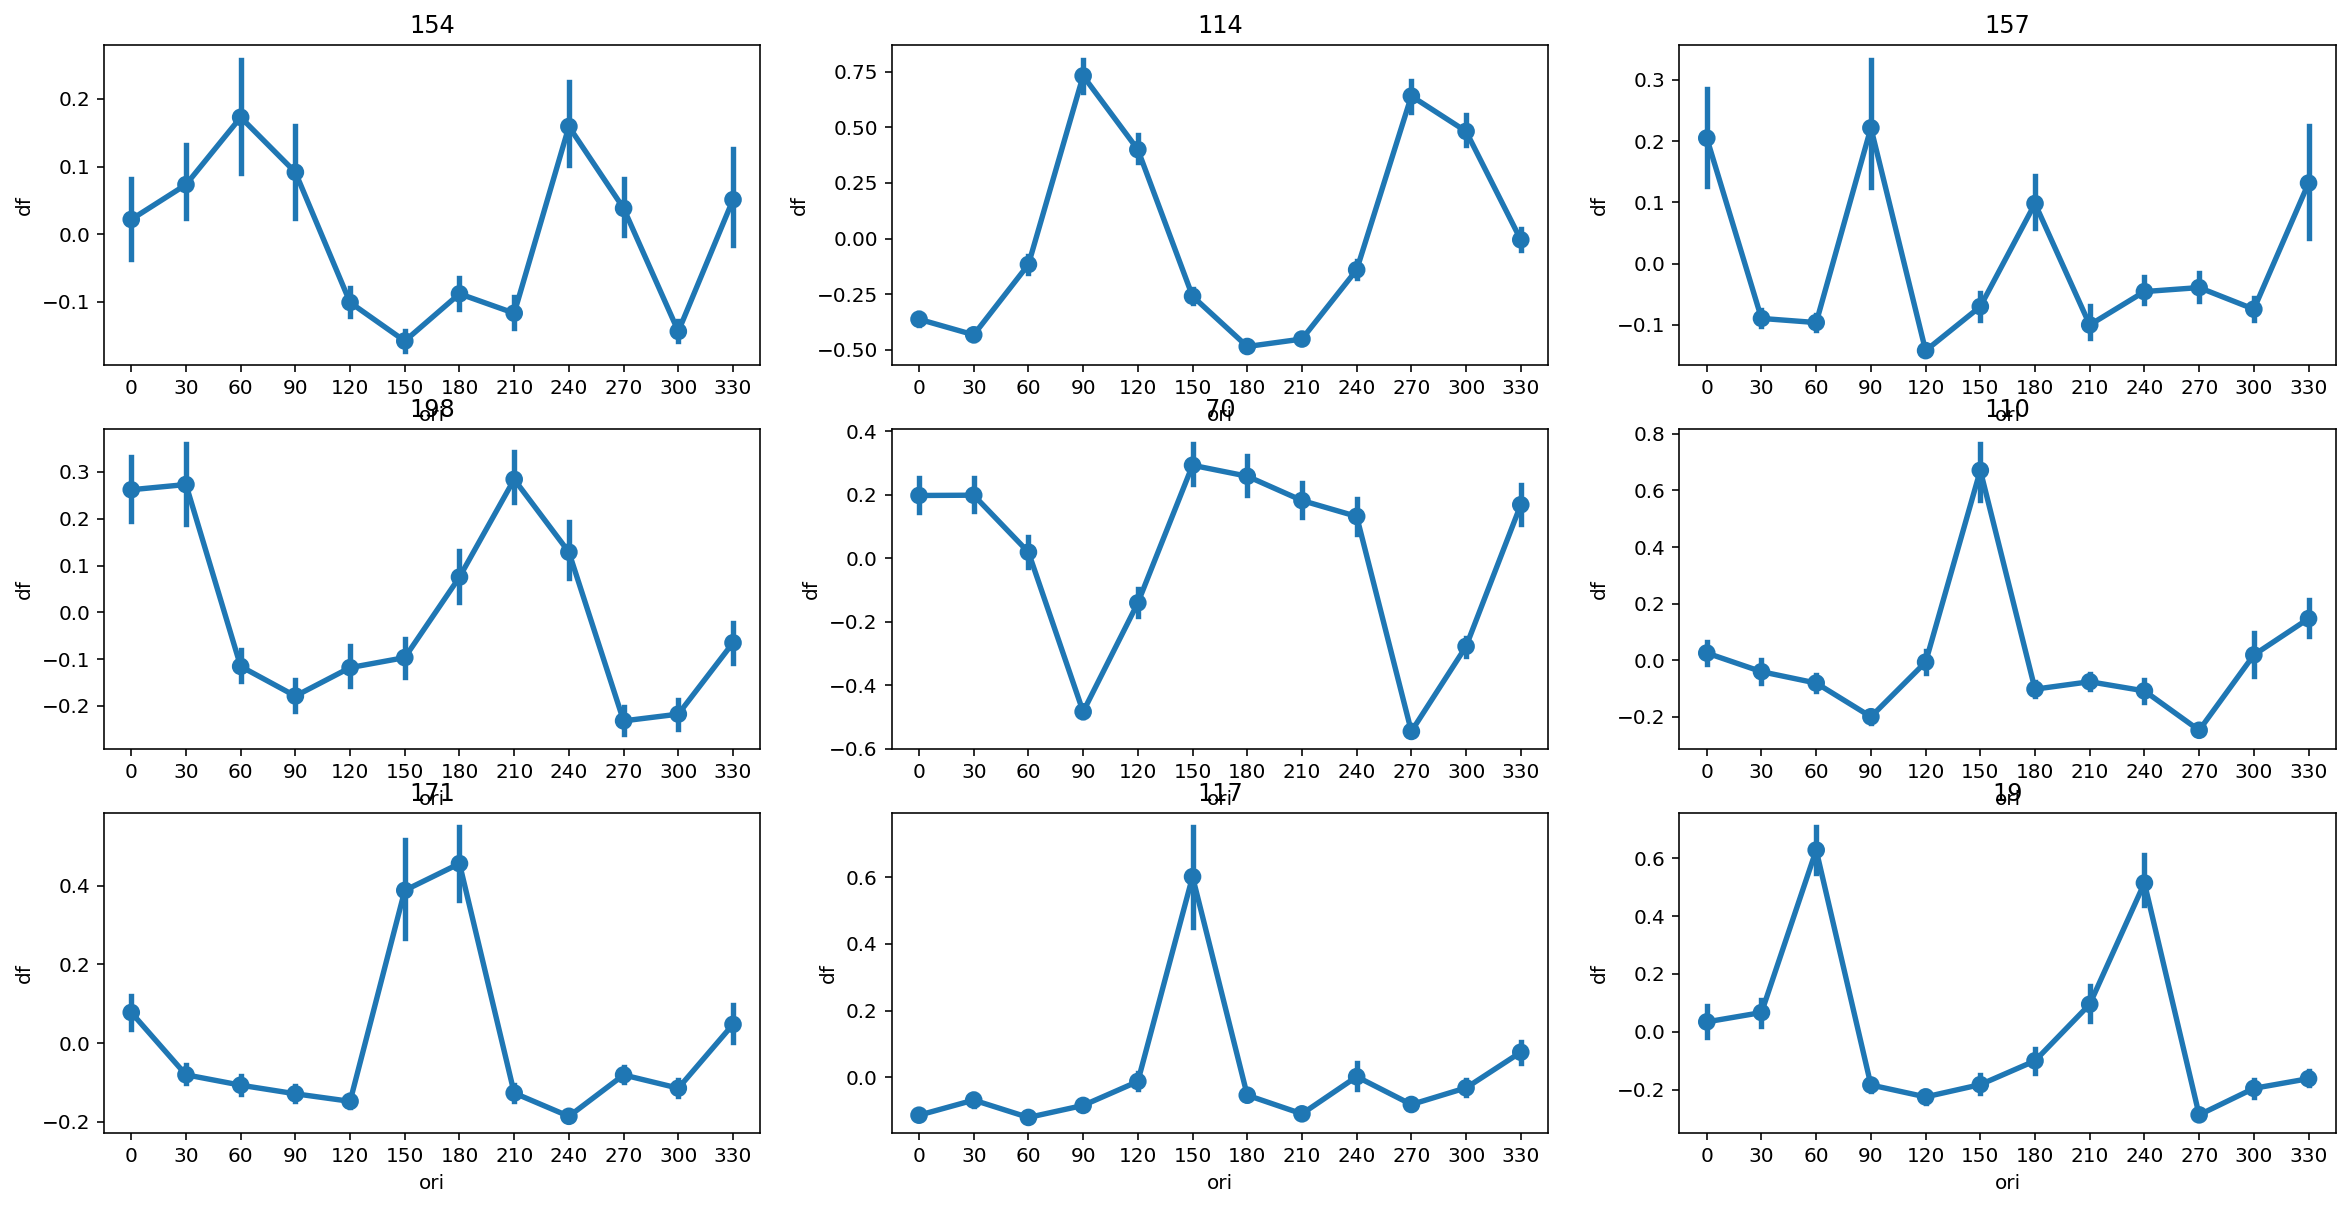

In [26]:
plot_df = df
# get examples of good osis
how_many =10
df2plt = plot_df[(plot_df.osi>0.02)]
#df2plt=plot_df[plot_df.vis_resp==True]
cells = np.random.choice(df2plt.cell.unique(), how_many, replace=False)

#fig, axs = plt.subplots(2,round(how_many/2), figsize=(15, 6), facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace = .5, wspace=.001)

fig, axes = plt.subplots(ncols=3, nrows=round((how_many)/3),figsize=(how_many*2, how_many*1))

for i, ax in zip(range(how_many), axes.flat):
    sns.pointplot(x='ori', y='df', data=df2plt[df2plt.cell==(cells[i])], kind='point', ax=ax)
    ax.set_title(str(cells[i]))
        

    #ax.axis('off')
    #ax.title('Example High OSI', size=16, weight='bold')

plt.savefig(out_path + 'tuning curves')
plt.show()

In [82]:
picked_df

NameError: name 'picked_df' is not defined

In [83]:
from scipy import optimize
df['ori'] = df['ori'].astype('float')
x_data = df.ori[df.cell==386].groupby(df['ori']).values()
y_data =  df.df[df.cell==386].groupby(df['ori']).values()
base[(base.cell==cell) & (base.power==power)].values



def test_func(x, a, b,c):
    return a * np.sin(b * x)+c

params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,
                                               p0=[3, 0.6,-0.2],absolute_sigma = True)

#And plot the resulting curve on the data

plt.figure(figsize=(6, 4))
plt.plot(x_data, y_data, label='Data')
plt.plot(x_data, test_func(x_data, params[0], params[1],params[2]),
         label='Fitted function')

plt.legend(loc='best')

plt.show()

AttributeError: 'SeriesGroupBy' object has no attribute 'values'

ValueError: setting an array element with a sequence.

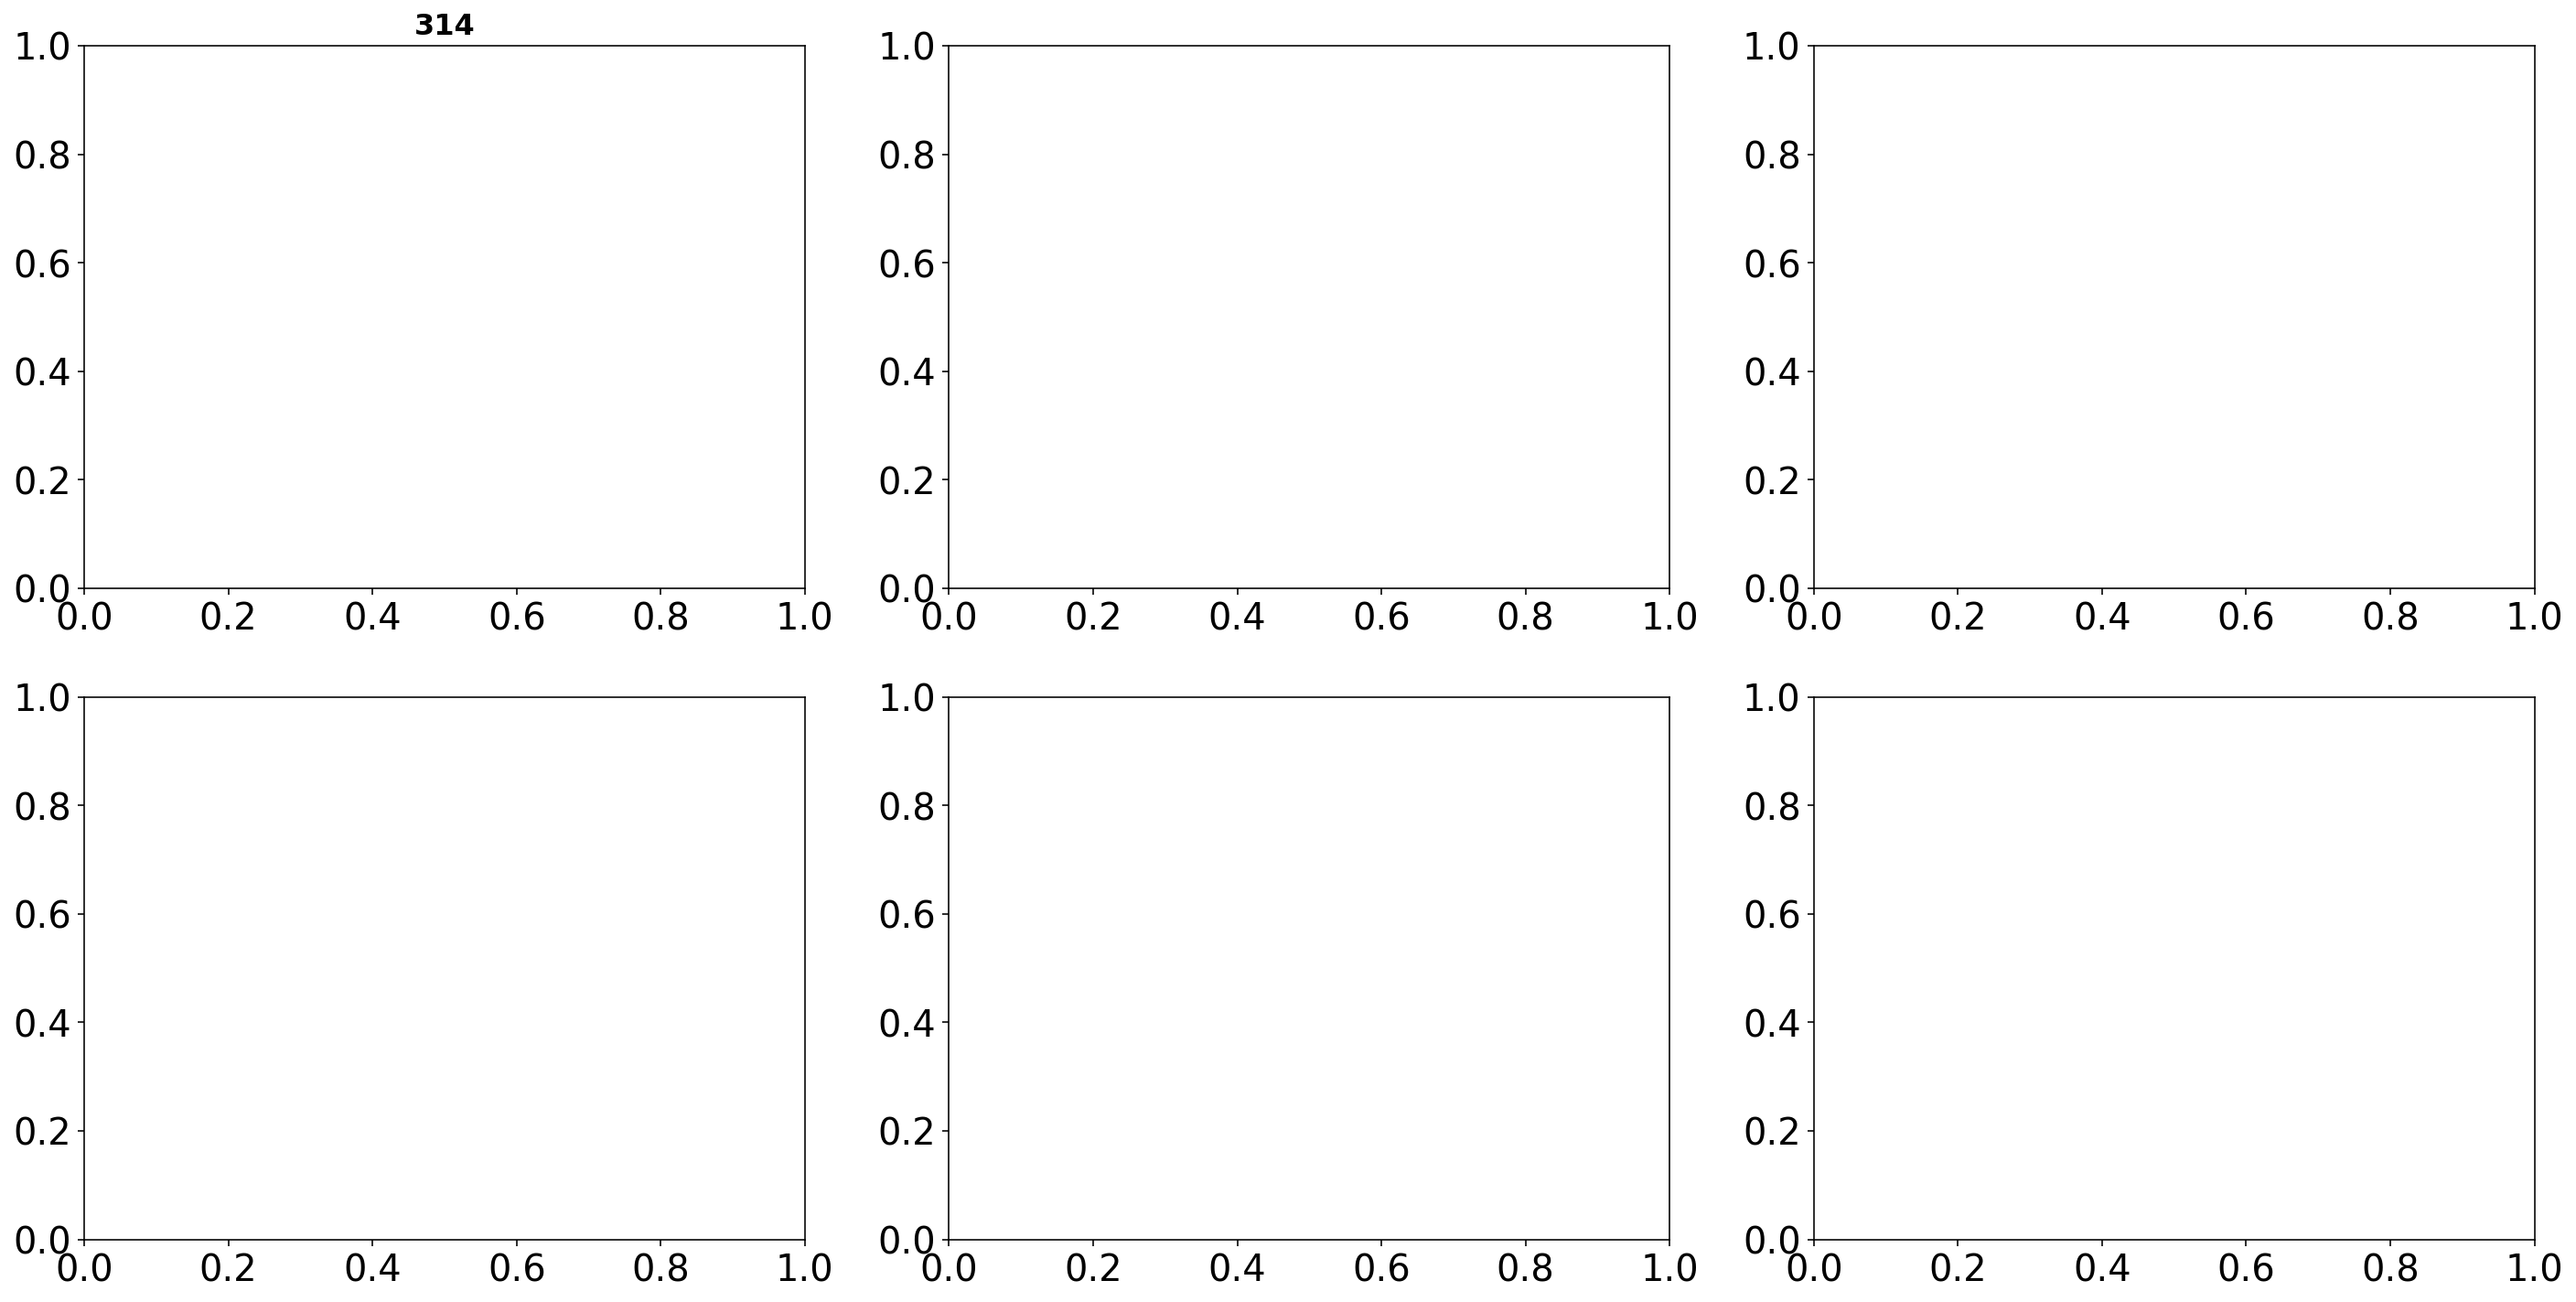

In [71]:
def test_func(x, a, b,c,d):
    return a * np.sin(b * x+c)+d
import math 

# get examples of good osis
how_many =6
#df2plt = plot_df[(plot_df.osi>0.1)]
df2plt = df[(plot_df.osi>0.02)&(plot_df.vis_resp==True)]
cells = np.random.choice(df2plt.cell.unique(), how_many)

x_data = df.ori[df.cell==1].groupby(df['ori'])
fig, axes = plt.subplots(ncols=3, nrows=round((how_many)/3),figsize=(how_many*4, how_many*2))

for i, ax in zip(range(how_many), axes.flat):
    
    ax.set_title(str(cells[i]),size=16, weight='bold')
    y_data =  df2plt.df[df2plt.cell==cells[i]].groupby(df['ori'])
    
    #data_x_sim =  np.arange(min(x_data),max(x_data)+1,.5)
    params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,
                                               p0=[3,2,1,-0.5],absolute_sigma = True)
    ax.plot(x_data, y_data,label='Data')
    ax.plot(x_data, test_func(x_data, params[0], params[1],params[2],params[3]),
         label='Fitted function')
    ax.legend(loc='best',fontsize=20)
    
    #ax.axis('off')
    #ax.title('Example High OSI', size=16, weight='bold')
#plt.axis('off')
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.xlim(0,360)
plt.show()


In [102]:
cell_393 =df[df.cell==393]

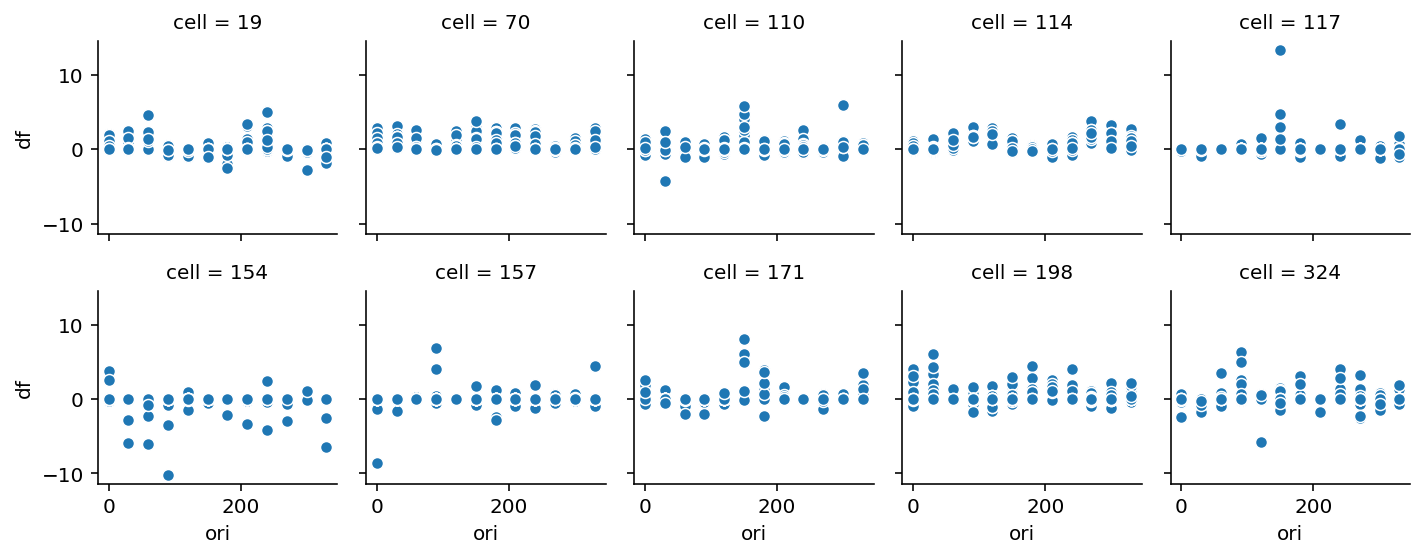

In [27]:
mdf = mean_df
sns.relplot(x='ori', y='df', data=mdf[mdf.cell.isin(cells)], col='cell', col_wrap=5, height= 2,aspect = 1)
plt.savefig(out_path +'more tuning curves')
plt.show()

<font size="5">save targets</font>

In [87]:
isOri = 60
orthOri = 150
#Select a physiologically interesting feature to save those targets
# (mean_df.vis_resp==True)
# (mean_df.vis_resp==True)
# iso_tuned = mean_df[(mean_df.pref == isOri)&(mean_df.vis_resp==True)&(mean_df.osi>0.0)].cell.unique() # if you want to filter by OSI, add (mean_df.osi>0.)
iso_tuned = mean_df[(mean_df.pref == isOri)&(mean_df.osi>0.0)].cell.unique()

# ortho_tuned = mean_df[(mean_df.pref == orthOri)&(mean_df.vis_resp==True)&(mean_df.osi>0.0)].cell.unique()
ortho_tuned = mean_df[(mean_df.pref == orthOri)&(mean_df.osi>0.0)].cell.unique()

In [88]:
iso_tuned.shape

(57,)

In [89]:
ortho_tuned

array([  1,   3,   6,   7,  16,  18,  22,  52,  71,  86, 102, 103, 106,
       118, 126, 133, 134, 139, 145, 147, 148, 149, 155, 161, 163, 170,
       173, 178, 184, 185, 186, 187, 194, 199, 216, 220, 223, 225, 232,
       236, 242, 244, 257, 262, 277, 280, 296, 297, 306, 308, 309, 323,
       326, 341, 352, 355, 367, 368, 369, 381, 386, 387, 396], dtype=int64)

In [90]:
visResp_cells = iso_tuned
nonVisResp_cells = ortho_tuned

#get the xy coordinates:
 # if you cropped the left side of the FOV we need to add this to the x coordinate to recover 512*512 FOV coorinates
dims = (512,x_end - x_start)
#caiman function cm.base.rois.com
XYcoords= cm.base.rois.com(cnm.estimates.A, d1=dims[0],d2=dims[1])
XYcoords[:,1] = XYcoords[:,1] + x_start #add the dX from the cut FOV

# array with cell # and xy locations for vis responsive cells
visResp_xy = np.zeros((visResp_cells.shape[0],3))
visResp_xy[:,0] = visResp_cells
visResp_xy[:,1:3] = XYcoords[visResp_cells]
# array with cell # and xy locations for non vis responsive cells
nonVisResp_xy = np.zeros((nonVisResp_cells.shape[0],3))
nonVisResp_xy[:,0] = nonVisResp_cells
nonVisResp_xy[:,1:3] = XYcoords[nonVisResp_cells]

In [91]:
x_start

100

In [92]:
iso_xy =  XYcoords[visResp_cells]
ortho_xy = XYcoords[nonVisResp_cells]

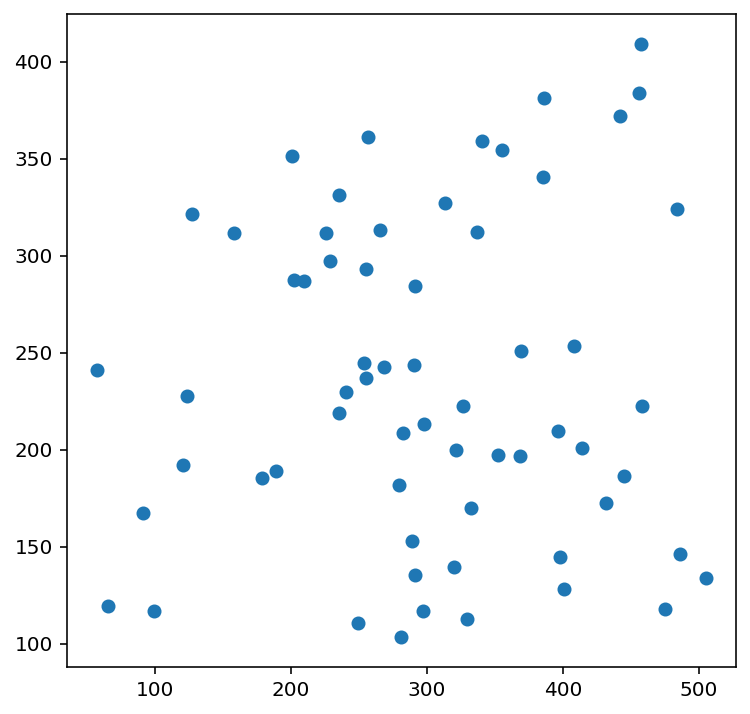

In [93]:
np.save(out_path + str(isOri)+'_tuned.npy',ortho_xy)
np.save(out_path + str(orthOri)+'_tuned.npy',iso_xy)

#save and verify the shape 
savemat(out_path + str(isOri)+'_tuned.mat', {'sources':iso_xy})
savemat(out_path +str(orthOri)+'_tuned.mat', {'sources':ortho_xy})
plt.figure(figsize=(6,6))
plt.scatter(ortho_xy[:,0],ortho_xy[:,1])

In [83]:
cell_ori_matrix = np.zeros((traces.shape[1],len(vis_id[0:7])))

for i,thisOri in enumerate(vis_id[0:7]):
    cell_ori_matrix[mean_df[(mean_df.pref == thisOri)&(mean_df.osi>0.0)].cell.unique(),i] = 10

In [84]:
mean_df

,cell,ori,trial,df,vis_resp,pval,pref,ortho,pdir,osi
0,0,0.0,2,-2.775558e-17,False,0.371932,60.0,150.0,240.0,0.034528
1,0,30.0,5,3.414893e-01,False,0.371932,60.0,150.0,240.0,0.034528
2,0,60.0,9,1.136498e-01,False,0.371932,60.0,150.0,240.0,0.034528
3,0,60.0,16,3.486408e-01,False,0.371932,60.0,150.0,240.0,0.034528
4,0,90.0,10,-3.562493e+00,False,0.371932,60.0,150.0,240.0,0.034528
...,...,...,...,...,...,...,...,...,...,...
7995,399,270.0,14,-1.933412e-06,False,0.898568,30.0,120.0,210.0,0.012230
7996,399,300.0,3,0.000000e+00,False,0.898568,30.0,120.0,210.0,0.012230
7997,399,300.0,15,0.000000e+00,False,0.898568,30.0,120.0,210.0,0.012230
7998,399,330.0,7,-9.699287e-01,False,0.898568,30.0,120.0,210.0,0.012230


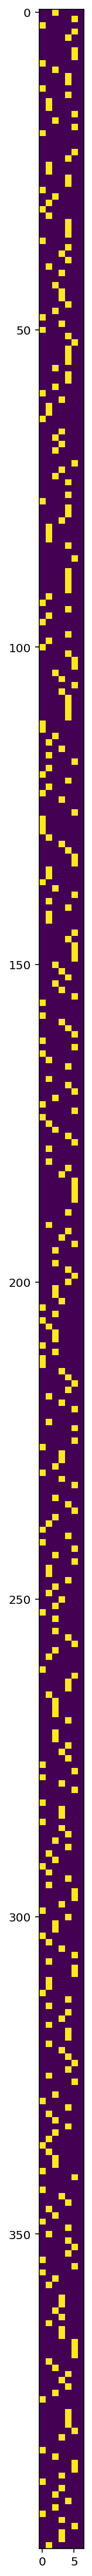

In [85]:
plt.figure(figsize=(6,40))
plt.imshow(cell_ori_matrix)



In [96]:
savemat(out_path + 'Matrix_All_tuned.mat', {'sources':cell_ori_matrix})
savemat(out_path + 'Matrix_All_XY.mat', {'sources':XYcoords})

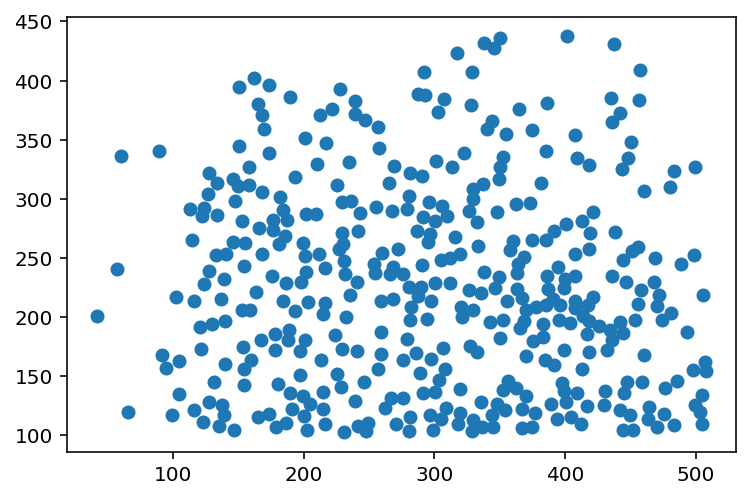

In [94]:
plt.scatter(XYcoords[:,0],XYcoords[:,1])

In [98]:
ISO = df[(df.vis_resp==True)&(df.pref == isOri)&(df.osi>0.02)]
ISO

,cell,trial,time,df,frame,ori,pref,ortho,pdir,osi,vis_resp
15360,96,0,0,-0.379718,0,225,0,90,180,0.022075,True
15361,96,1,0,0.086514,0,90,0,90,180,0.022075,True
15362,96,2,0,-0.239770,0,270,0,90,180,0.022075,True
15363,96,3,0,-0.378996,0,315,0,90,180,0.022075,True
15364,96,4,0,-0.379715,0,180,0,90,180,0.022075,True
...,...,...,...,...,...,...,...,...,...,...,...
5251995,412,155,4.93333,-0.484902,74,135,0,90,270,0.029276,True
5251996,412,156,4.93333,-0.543203,74,90,0,90,270,0.029276,True
5251997,412,157,4.93333,-0.549677,74,225,0,90,270,0.029276,True
5251998,412,158,4.93333,0.822355,74,0,0,90,270,0.029276,True


<font size="5">PIPELINE FOR CONTRAST MODULATED NOISE </font>

--> we're gonna call the contrast 'ori' for coding confort

In [90]:
#for CONTRAST MODULATED NOISE EXPERIMENTS
vis_id= tuple(np.squeeze(np.array(mat1['stimConds'][:,5])))
vis_oris =  tuple((np.squeeze(np.array(mat1['shuffleStims'][:]))))
fr = 15

In [91]:
vis_df = create_df(traces, vis_stim=vis_oris, vis_name='ori', fr=fr)

In [92]:
vis_df

,cell,trial,time,df,frame,ori
0,0,0,0,-0.022125,0,5.0
1,0,1,0,-0.022125,0,2.0
2,0,2,0,-0.022125,0,4.0
3,0,3,0,-0.022125,0,1.0
4,0,4,0,-0.022125,0,3.0
...,...,...,...,...,...,...
3941995,437,115,4.93333,-0.307763,74,6.0
3941996,437,116,4.93333,-0.307763,74,3.0
3941997,437,117,4.93333,-0.307763,74,2.0
3941998,437,118,4.93333,-0.307763,74,1.0


In [93]:
win= (1.5,2,2.1,4.5) 
col = 'ori'
mean_df = meanby(vis_df, win,col)
mean_df

,cell,ori,trial,df
0,0,1.0,3,0.000000e+00
1,0,1.0,11,0.000000e+00
2,0,1.0,16,0.000000e+00
3,0,1.0,19,0.000000e+00
4,0,1.0,28,0.000000e+00
...,...,...,...,...
52555,437,6.0,91,-3.701677e-04
52556,437,6.0,99,-1.110223e-16
52557,437,6.0,106,-1.110223e-16
52558,437,6.0,110,-1.026310e-02


In [94]:
vis_cells, p_vals = find_vis_resp(mean_df, p=0.1, test='anova')
vis_df.loc[:, 'vis_resp'] = False
vis_df.loc[vis_df.cell.isin(vis_cells), 'vis_resp'] = True

vis_df = vis_df.join(pd.Series(p_vals, name='pval'), on='cell')
vis_df

There are 205 visually responsive cells, out of 438 (46.80%)


,cell,trial,time,df,frame,ori,vis_resp,pval
0,0,0,0,-0.022125,0,5.0,False,0.421115
1,0,1,0,-0.022125,0,2.0,False,0.421115
2,0,2,0,-0.022125,0,4.0,False,0.421115
3,0,3,0,-0.022125,0,1.0,False,0.421115
4,0,4,0,-0.022125,0,3.0,False,0.421115
...,...,...,...,...,...,...,...,...
3941995,437,115,4.93333,-0.307763,74,6.0,False,0.647137
3941996,437,116,4.93333,-0.307763,74,3.0,False,0.647137
3941997,437,117,4.93333,-0.307763,74,2.0,False,0.647137
3941998,437,118,4.93333,-0.307763,74,1.0,False,0.647137


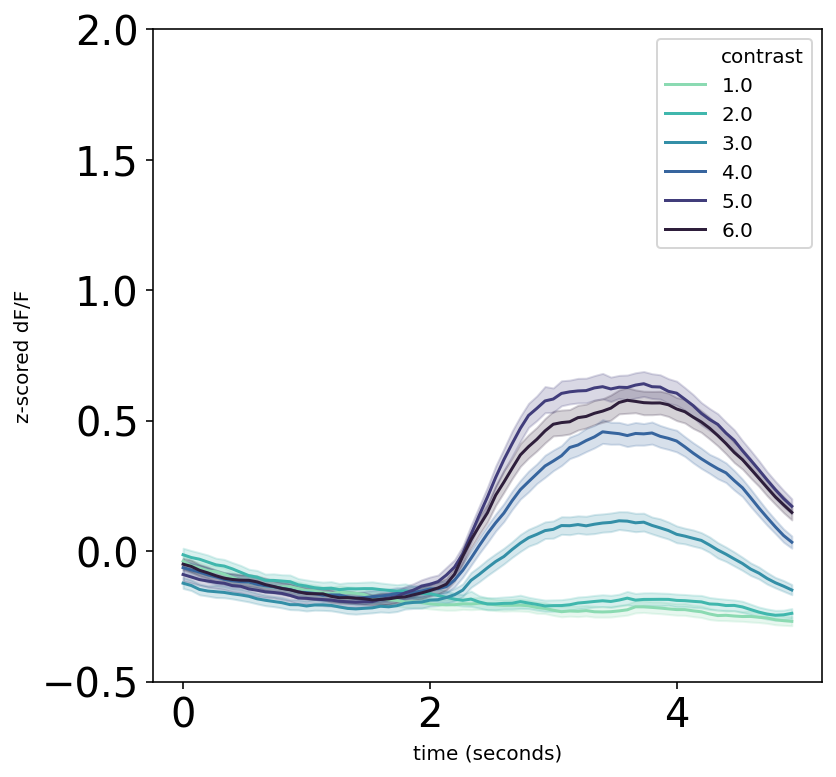

In [95]:
df=vis_df
plt.figure(figsize=(6,6))
df['ori'] = df['ori'].astype('category') # this tells pandas that the variable ori is not a numerical but rather a cathegorical so it can be used as a real "hue" in the lineplots
df= df.rename(columns={'ori':'contrast'})
data= df[df.vis_resp==True]

#palette="ch:2.5,.25"
#plot contrast responses in visually responsive cells
palette = sns.color_palette("mako_r", len(vis_id))
sns.lineplot(x='time', y='df', hue='contrast', data=data,palette=palette)
plt.xlabel('time (seconds)')
plt.ylabel('z-scored dF/F')
plt.ylim(-0.5,2)

plt.savefig(out_path + 'psths by contrast Vis responsive')
plt.show()

In [96]:
df

,cell,trial,time,df,frame,contrast,vis_resp,pval
0,0,0,0,-0.022125,0,5.0,False,0.421115
1,0,1,0,-0.022125,0,2.0,False,0.421115
2,0,2,0,-0.022125,0,4.0,False,0.421115
3,0,3,0,-0.022125,0,1.0,False,0.421115
4,0,4,0,-0.022125,0,3.0,False,0.421115
...,...,...,...,...,...,...,...,...
3941995,437,115,4.93333,-0.307763,74,6.0,False,0.647137
3941996,437,116,4.93333,-0.307763,74,3.0,False,0.647137
3941997,437,117,4.93333,-0.307763,74,2.0,False,0.647137
3941998,437,118,4.93333,-0.307763,74,1.0,False,0.647137


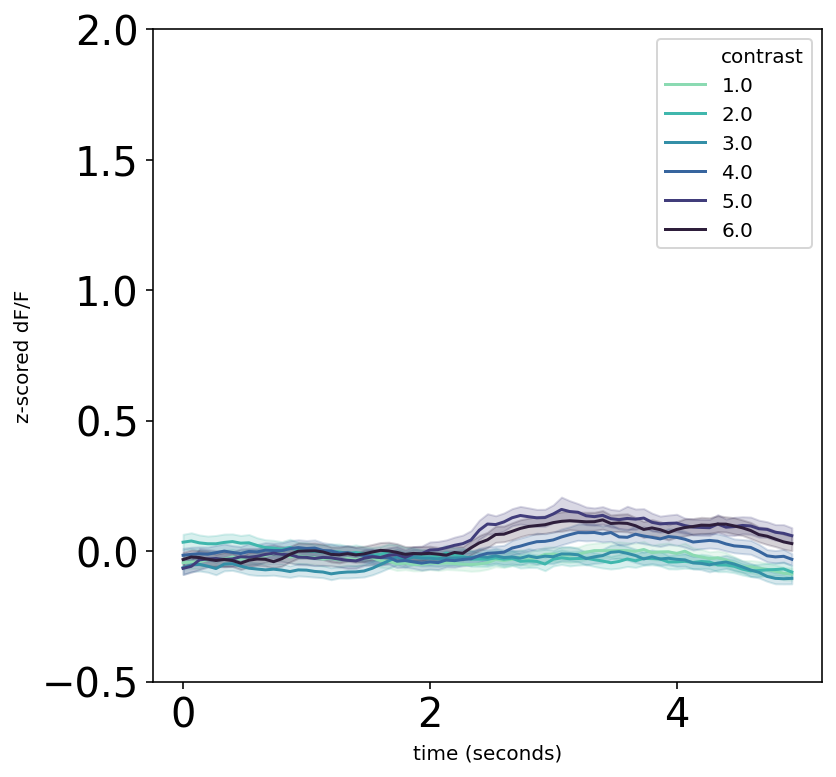

In [97]:
df=vis_df
plt.figure(figsize=(6,6))
df['ori'] = df['ori'].astype('category') # this tells pandas that the variable ori is not a numerical but rather a cathegorical so it can be used as a real "hue" in the lineplots
df= df.rename(columns={'ori':'contrast'})
data= df[df.vis_resp==False]

#palette="ch:2.5,.25"
#plot contrast responses in visually responsive cells
palette = sns.color_palette("mako_r", len(vis_id))
sns.lineplot(x='time', y='df', hue='contrast', data=data,palette=palette)
plt.xlabel('time (seconds)')
plt.ylabel('z-scored dF/F')
plt.ylim(-0.5,2)

plt.savefig(out_path + 'psths by contrast NON Vis responsive')
plt.show()

In [ ]:
#Select a physiologically interesting feature to save those targets
visResp_cells = df[df.vis_resp==True].cell.unique()
nonVisResp_cells = df[df.vis_resp==False].cell.unique()


In [ ]:

#get the xy coordinates:
x_start = x_start # if you cropped the left side of the FOV we need to add this to the x coordinate to recover 512*512 FOV coorinates
dims = (512,400)
#caiman function cm.base.rois.com
XYcoords= cm.base.rois.com(cnm.estimates.A, d1=dims[0],d2=dims[1])
XYcoords[:,1] = XYcoords[:,1] + x_start #add the dX from the cut FOV
i = [1, 0]
XYCoords = XYcoords[:,i] #swap them

# array with cell # and xy locations for vis responsive cells
visResp_xy = np.zeros((visResp_cells.shape[0],3))
visResp_xy[:,0] = visResp_cells
visResp_xy[:,1:3] = XYcoords[visResp_cells]
# array with cell # and xy locations for non vis responsive cells
nonVisResp_xy = np.zeros((nonVisResp_cells.shape[0],3))
nonVisResp_xy[:,0] = nonVisResp_cells
nonVisResp_xy[:,1:3] = XYcoords[nonVisResp_cells]

In [ ]:
np.save(out_path + 'nonVisResp_xy.npy',nonVisResp_cells)
np.save(out_path + 'visResp_xy.npy',visResp_cells)

<font size="5">PIPELINE FOR STIM TEST </font>

--> under developement

<font color='red'>copy and adapt,py_get_psth,and nodaq_stimtest_df functions</font> 

get caiman xy coordinates in 512x512 pixel space

In [10]:
import scipy.io as sio
daq_path = 'Y://frankenshare//holographyS//Satsuma//200729//MBOT5_419_Chrome2s//200729_MBOT5_419_Chrome2s_A.mat'
mat = sio.loadmat(daq_path) 

# Important experiment information!

power_list = ((mat['ExpStruct'][0,0]['outParams'][0,0]['power'][0])*1000).astype('int16')
mouse_id = mat['ExpStruct'][0,0]['mouseID'][0]
trialCond= mat['ExpStruct'][0,0]['trialCond'][0]

print(f'Mouse ID:        {mouse_id}')
print(f'Powers (mW):     {power_list.tolist()}')
fr = 15

Mouse ID:        MBOT5_419_Chrome2s
Powers (mW):     [0, 75, 50, 100]


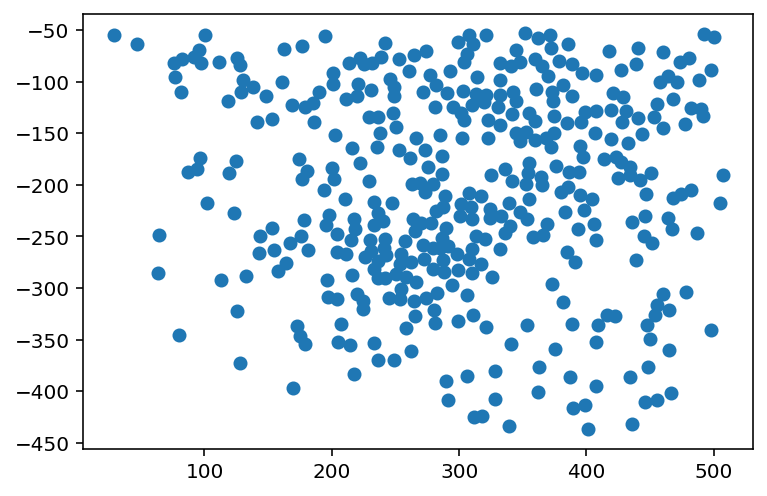

In [11]:
#get the xy coordinates:
x_start = 50 # if you cropped the left side of the FOV we need to add this to the x coordinate to recover 512*512 FOV coorinates
dims = (512,400)
#caiman function cm.base.rois.com
XYcoords= cm.base.rois.com(cnm.estimates.A, d1=dims[0],d2=dims[1])
XYcoords[:,1] = XYcoords[:,1] + x_start #add the dX from the cut FOV
#i = [1, 0]
#XYCoords = XYcoords[:,i] #swap them
plt.scatter(XYcoords[:,0],-XYcoords[:,1])

In [14]:
mapping = get_target_mapping_caiman(mat, XYcoords)   

mapping

array([  2,   9,  15,  16,  17,  19,  21,  23,  22,  25,  26,  21,  29,
        31,  32,  33,  25,  34,  36,  38,  43,  48,  40,  44,  50,  45,
        49,  47,  53,  54,  56,  62,  60,  73,  58,  57,  72,  64,  67,
        69,  68,  70,  64,  73,  92,  83,  81,  85,  87,  94,  90,  89,
        93,  96,  97,  98, 104, 103,  99, 106, 107, 113, 110, 109, 112,
       121, 114, 118, 120, 122, 125, 124, 127, 129, 134, 137, 153, 140,
       153, 145, 165, 146, 147, 150, 149, 164, 154, 157, 159, 160, 158,
       162, 163, 161, 169, 171, 174, 141, 172, 179, 178, 181, 182, 185,
       184, 195, 188, 187, 191, 193, 190, 197, 196, 203, 204, 207, 206,
       211, 224, 215, 221, 217, 227, 228, 230, 231, 229, 238, 237, 234,
       239, 241, 242, 240, 243, 248, 252, 258, 255, 259, 261, 262, 264,
       267, 270, 272, 273, 279, 280, 282, 286, 283, 287, 288, 274, 294,
       283, 303, 295, 309, 297, 300, 298, 305, 306, 312, 304, 313, 314,
       317, 320, 321, 323, 318, 324, 327, 325, 326, 328, 329, 33

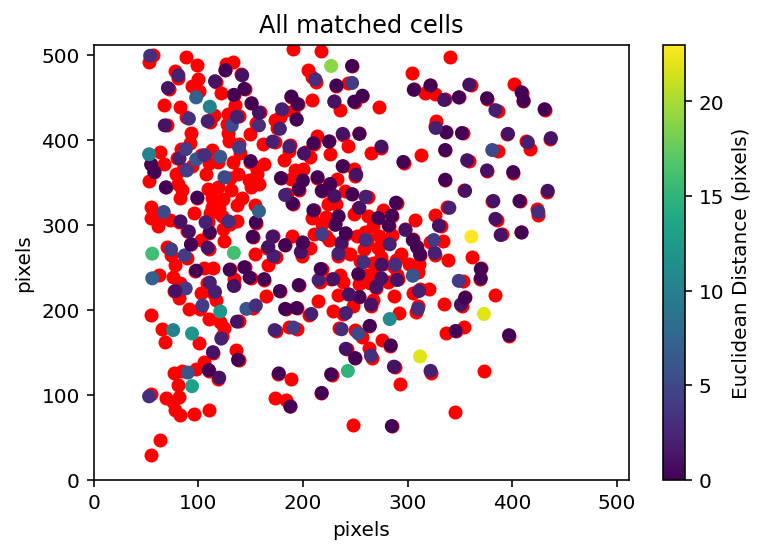

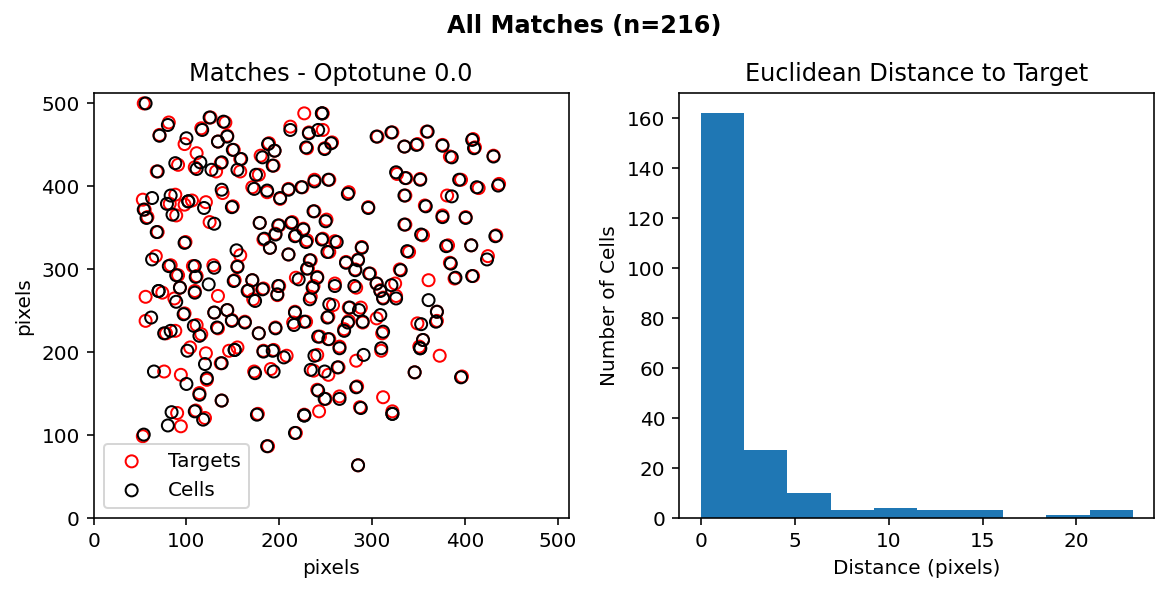

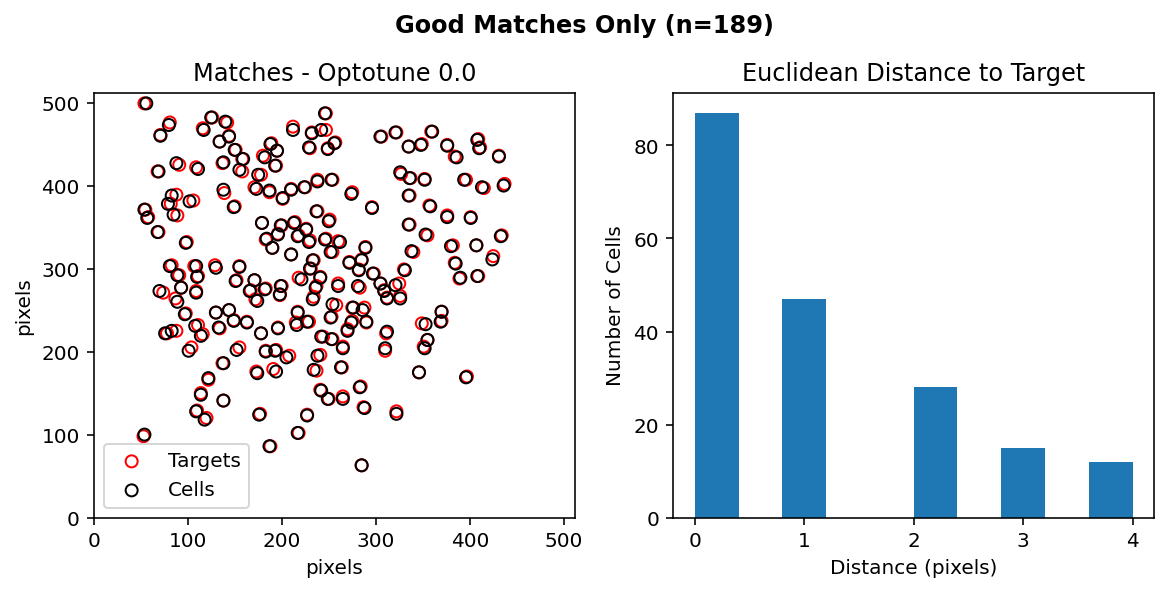

In [15]:
# check holo targeting, reject cells that are >10 pixels away
threshold = 5 # in pixels
good = map_targs_caiman(threshold, mat, XYcoords, save=True, save_path=out_path)

In [29]:
#try this
traces1 = traces[:,mapping,:]
pre_time = 7
length = 40
# get stim times for multitarget holos
pulses = mat['ExpStruct'][0,0]['outParams'][0,0]['pulses'][0,1]
cellsPerHolo = mat['ExpStruct'][0,0]['outParams'][0,0]['cellsPerHolo'][0,1]
daqFs = mat['ExpStruct'][0,0]['daqParams'][0,0]['Fs'][0,0]
A = (np.where(np.diff(mat['ExpStruct'][0,0]['outParams'][0,0]['nextholoTrigger'][:,1])>0)[0])
A=A[0:-1:2]
B=A[0:-1:pulses]
first_stim_times = B*fr/daqFs 

#get online psths
online_psths = np.zeros((int(np.shape(traces1)[0]), int(np.shape(traces1)[1]), length))
NCells = traces1.shape[1]
listOfHolos = (np.arange(0,traces1.shape[1],cellsPerHolo).tolist())
for i in range (traces1.shape[0]):
    for n,cell in enumerate(listOfHolos[:-1]):
        real_start = first_stim_times[n].astype('int16')-pre_time
        real_end = real_start+length
        takeThisCells= min(cell+cellsPerHolo,NCells)
        online_psths[i,cell:takeThisCells,:] = traces1[i,cell:takeThisCells,real_start:real_end]

In [24]:
len(first_stim_times.astype(int))

21

In [35]:
first_stim_times

array([ 7.4235 ,  9.92325, 12.42375, 14.9235 , 17.42325, 19.92375,
       22.4235 , 24.92325, 27.42375, 29.9235 , 32.42325, 34.92375,
       37.4235 , 39.92325, 42.42375, 44.9235 , 47.42325, 49.92375,
       52.4235 , 54.92325, 57.42375])

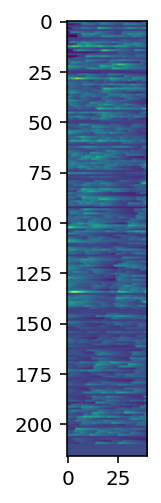

In [27]:
plt.imshow(online_psths[0,:,:])

In [250]:
np.where(np.diff(mat['ExpStruct'][0,0]['outParams'][0,0]['nextholoTrigger'][:,1])>0)[0]

array([ 9898,  9999, 10565, 10666, 11231, 11332, 11898, 11999, 12565,
       12666, 13231, 13332, 13898, 13999, 14565, 14666, 15231, 15332,
       15898, 15999, 16565, 16666, 17231, 17332, 17898, 17999, 18565,
       18666, 19231, 19332, 19898, 19999, 20565, 20666, 21231, 21332,
       21898, 21999, 22565, 22666, 23231, 23332, 23898, 23999, 24565,
       24666, 25231, 25332, 25898, 25999, 26565, 26666, 27231, 27332,
       27898, 27999, 28565, 28666, 29231, 29332, 29898, 29999, 30565,
       30666, 31231, 31332, 31898, 31999, 32565, 32666, 33231, 33332,
       33898, 33999, 34565, 34666, 35231, 35332, 35898, 35999, 36565,
       36666, 37231, 37332, 37898, 37999, 38565, 38666, 39231, 39332,
       39898, 39999, 40565, 40666, 41231, 41332, 41898, 41999, 42565,
       42666, 43231, 43332, 43898, 43999, 44565, 44666, 45231, 45332,
       45898, 45999, 46565, 46666, 47231, 47332, 47898, 47999, 48565,
       48666, 49231, 49332, 49898, 49999, 50565, 50666, 51231, 51332,
       51898, 51999,

In [28]:
# Get stim times and target mapping
first_stim_times = mat['ExpStruct'][0,0]['outParams'][0,0]['firstStimTimes'][:,1]
first_stim_times = first_stim_times[~np.isnan(first_stim_times)] #wills suggestion to solve the indexing error
# original code: first_stim_times *= fs 
first_stim_times *= fr

#get online psths
online_psths = np.zeros((int(np.shape(traces1)[0]), int(np.shape(traces1)[1]), length))
for i in range (traces1.shape[0]):
    for cell in range(traces1.shape[1]):
        real_start = first_stim_times[cell].astype('int16')-pre_time
        real_end = real_start+length
        online_psths[i,cell,:] = traces1[i,cell,real_start:real_end]

SyntaxError: invalid syntax (<ipython-input-28-544d2bcda90c>, line 8)

In [31]:
stim_df = create_df(online_psths, vis_stim=trialCond, vis_name='power', fr=fr)
# append target mapping to dataframe
stim_df['badmatch'] = True
stim_df.loc[stim_df.cell.isin(good), 'badmatch'] = False

In [32]:
df = stim_df[(stim_df.badmatch == False)]
psths = online_psths

In [33]:
from vis import meanby
# where to look based on pre_time
pre1 = 0 #fisrt frame for baseline
pre2 = 6 #last frame for baseline
post1=11 #fisrt frame for response
post2=15 #last frame for response
times1 = (pre1, pre2, post1, post2)
win = (pre1/fr, pre2/fr, post1/fr, post2/fr)

C:\Users\Scanimage\anaconda3\envs\caiman\lib\site-packages\scipy\stats\stats.py:5760: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
C:\Users\Scanimage\anaconda3\envs\caiman\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Scanimage\anaconda3\envs\caiman\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Scanimage\anaconda3\envs\caiman\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


0
2
15
7


<Figure size 432x288 with 0 Axes>

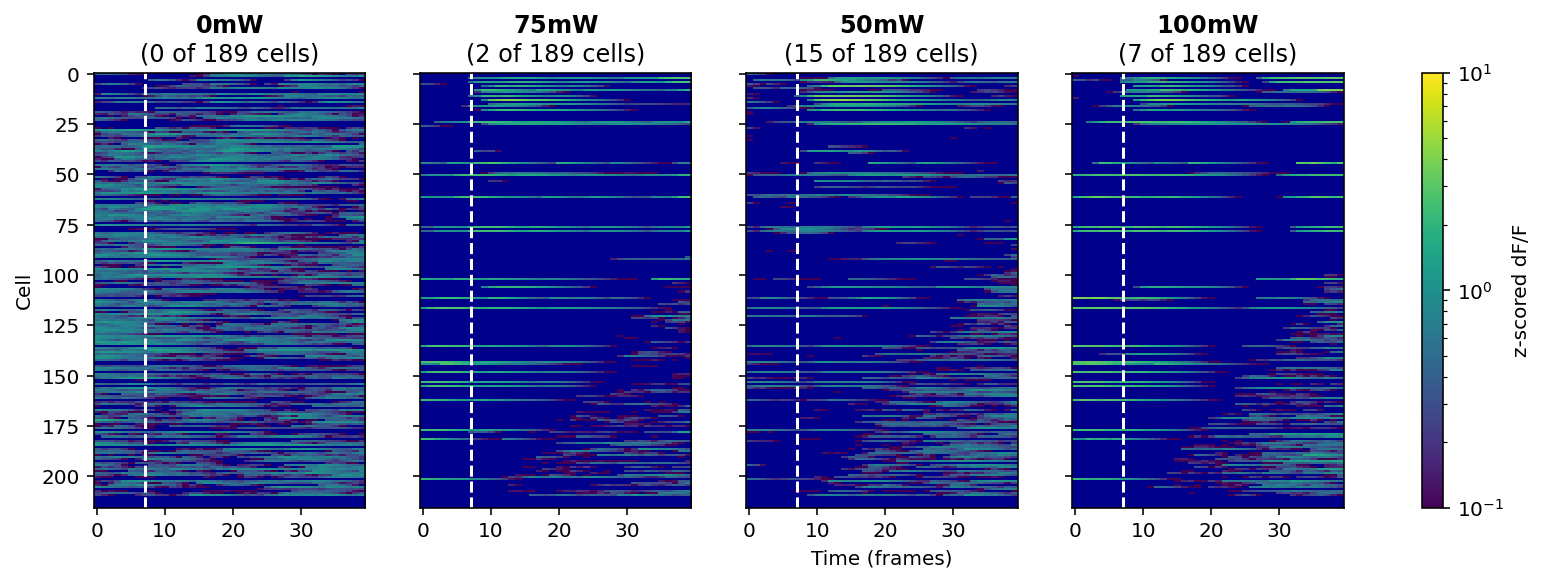

In [34]:
from vis import find_vis_resp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import f_oneway,ttest_rel,wilcoxon,ranksums


# plot settings
plt.set_cmap('viridis') #[viridis, magma, inferno, plasma, seismic] for more...https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

cmap = plt.cm.viridis
cmap.set_bad(color='darkblue')


fig, ax = plt.subplots(1,len(power_list), sharey=True, sharex=True, figsize=(14,4))
ax = ax.ravel()
nstim = np.empty(len(power_list), dtype='int32')
stimmable_cells=[]
#sns.despine(top=False, right=False)
# plotting
for i,p in enumerate(power_list):
    img = ax[i].imshow(np.nanmean(psths[df[(df.power==i+1)].trial.unique(),:,:],0), aspect='auto',norm=colors.LogNorm(vmin=0.1, vmax = 10),interpolation='nearest')
    ps2,cells = get_stimmable_pre_post(df,i,win,0.01)
    ntot = len(ps2)
    ncells = cells.size
    nstim[i] = ncells
    stimmable_cells.append(cells)
    print(ncells)
    ax[i].set_title(r"$\bf{" + str(p) +  "mW}$" + f'\n({ncells} of {ntot} cells)')
    ax[i].axvline(pre_time, c='w', ls='--')
    

fig.colorbar(img, ax=ax, label='z-scored dF/F')
ax[len(ax)//2].set_xlabel('Time (frames)')
ax[0].set_ylabel('Cell')

plt.savefig(out_path+ 'psths by power_online_caiman ALL CELLS_max_p001')
plt.show()


# save stimmable cells as a numpy array
#stimmable_cells1 = cells


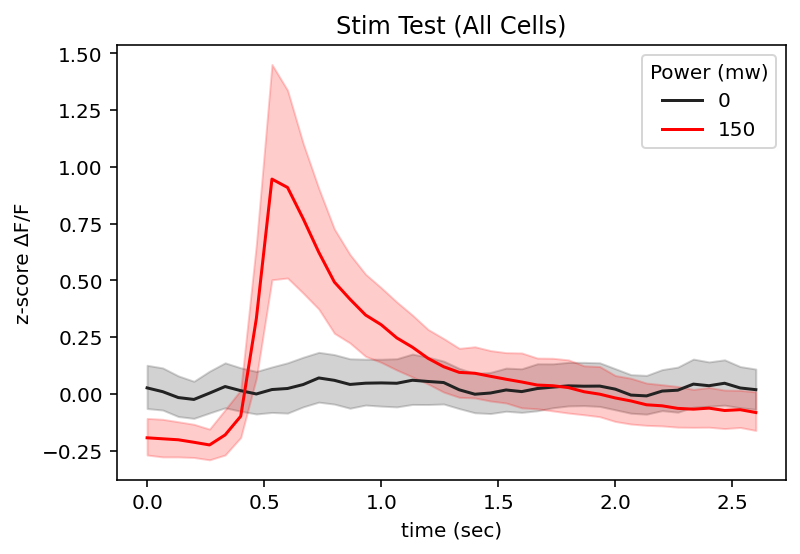

In [49]:
# plot mean holo PSTHs traces with seaborn, no contrast
p = sns.dark_palette('red', as_cmap=True)
sns.lineplot(x='time',y='df',data=df, hue='power', palette=p);
plt.xlabel('time (sec)')
plt.ylabel('z-score ΔF/F')
#plt.ylim(-0.1, 0.4)
plt.title('Stim Test (All Cells)')
plt.legend(power_list.tolist(), title='Power (mw)')
plt.savefig(out_path + 'psth traces by power_online_caiman')
plt.show()

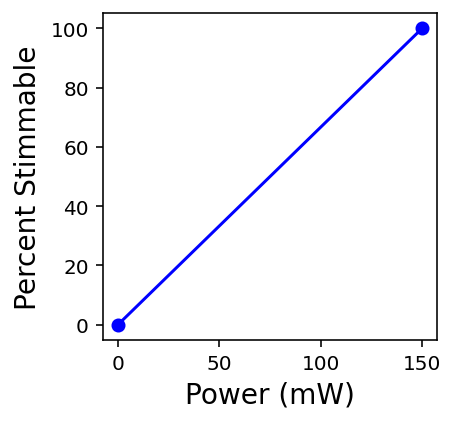

In [50]:
# plot saturation curve
pstim = nstim / nstim[-1] * 100
fig = plt.figure(figsize=(3,3))
plt.plot(power_list, pstim, marker='o', c='b')
plt.ylim(0,100)
plt.ylabel('Percent Stimmable', fontsize=14)
plt.xlabel('Power (mW)', fontsize=14)
plt.axis('tight')
plt.savefig(out_path + 'holo pwr saturation curve_online_caiman')
plt.show()

In [51]:
stimmable_cells

[array([], dtype=float64),
 array([ 0.,  1.,  2.,  3.,  4.,  7.,  8., 10., 12., 13., 14., 16., 17.,
        18., 19., 21., 22., 23., 26., 27., 29.])]

In [52]:
#append stimmable
df.loc[:, 'stimmable'] = False
df.loc[df.cell.isin(cells), 'stimmable'] = True

In [53]:
df[df.stimmable==True].cell.unique()

array([ 0,  1,  2,  3,  4,  7,  8, 10, 12, 13, 14, 16, 17, 18, 19, 21, 22,
       23, 26, 27, 29], dtype=int64)

In [54]:
#get the xy coordinates:
x_start = x_start # if you cropped the left side of the FOV we need to add this to the x coordinate to recover 512*512 FOV coorinates
dims = (512,400)
#caiman function cm.base.rois.com
XYcoords= cm.base.rois.com(cnm.estimates.A, d1=dims[0],d2=dims[1])
XYcoords[:,1] = XYcoords[:,1] + x_start #add the dX from the cut FOV
i = [1, 0]
XYCoords = XYcoords[:,i] #swap them

# array with cell # and xy locations for vis responsive cells
stimmable={}
stimmable['date'] = date
stimmable['mouse'] = mouse
stimmable['exp_name'] = exp_name
stimmable['XY_stimmable']= XYcoords[df[df.stimmable==True].cell.unique()]
stimmable['cells_per_power']=stimmable_cells
stimmable['powers']=power_list

In [55]:
import pickle
f = open(out_path +'stimmable.pkl',"wb")
pickle.dump(stimmable,f)
f.close()

In [56]:
m=pickle.load( open( out_path +'stimmable.pkl', "rb" ) )

In [57]:
savemat(out_path +'stimmableXY.mat', {'XY':stimmable['XY_stimmable']})
savemat(out_path +'stimmableId.mat', {'CellId':stimmable['cells_per_power'][-1]})

In [58]:
np.where(trialCond == min(trialCond))

(array([ 0,  2,  3,  6, 10, 12, 16, 17, 18, 19], dtype=int64),)

In [59]:
traces[np.where(trialCond == max(trialCond))].shape

(10, 438, 172)

In [60]:
mean_traces_stim = np.mean(traces[np.where(trialCond == max(trialCond))],0)
mean_traces_ctrl= np.mean(traces[np.where(trialCond == min(trialCond))],0)

In [61]:
np.save(out_path+'mean_traces_stim_ORTHO', mean_traces_stim )
np.save(out_path+'mean_traces_ctrl_ORTHO', mean_traces_ctrl )

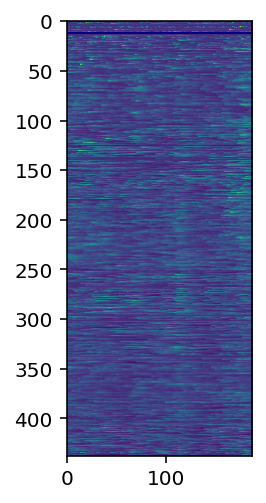

In [30]:
plt.imshow(mean_traces_ctrl)

In [62]:
out_path

'D://Mora//20200722//MBOT5_419//testOrtho2////out//'

In [12]:
#mapping and stimmability aux functions for holography


def map_targs_caiman(thresh, mat,  XYCoord_caiman, save=False, save_path=''):
    """
    Map the targets during a holography experiment onto caiman detected cells.
    Excludes cells with a euclidian distance greater than a provided threshold.

    Inputs:
        XYCoord_caiman (np.array): coodinates from the caiman detected cells in 512x512 pixel space
        thresh(int): threshold distance (in pixels) to start exlusions
        

    Outputs:
        (cool graphs)
        good (array): numpy array of the good cells (under threshold distance)
    """

    holo_targs = mat['ExpStruct'][0,0]['holoRequest'][0,0]['targets']
    medians = XYCoord_caiman
    planes = np.zeros(medians.shape[0])
    planes_key = np.unique(holo_targs[:,2])
    planes_key.sort()

    target_mapping = np.empty((holo_targs.shape[0],),dtype='int16')
    cell_loc = np.empty((holo_targs.shape[0],3),dtype='int16')
    targ_loc = np.empty((holo_targs.shape[0],3),dtype='int16')
    dists = np.empty((holo_targs.shape[0],2),dtype='int16')

    opto_planes = np.unique(holo_targs[:,2])

    for i,p in enumerate(np.unique(planes)):
        planes[planes == p] = opto_planes[i]

    cells = np.column_stack([medians, planes])

    for i,p in enumerate(planes_key):

        if i == 1:
            cells[cells[:,2]==p] = cells[cells[:,2]==p] - np.array([0, 512, 0])
        elif i == 2:
            cells[cells[:,2]==p] = cells[cells[:,2]==p] - np.array([512,0, 0])

    for i,targ in enumerate(holo_targs):
        plane_idx = targ[2]
        meds_this_plane = cells[cells[:,2]==plane_idx]
        cells_this_plane = np.where(planes==plane_idx)[0]

        distances = np.linalg.norm(meds_this_plane[:,:2]-targ[:2], axis=1)
        idx_best_match = np.argmin(distances)

        targ_xyz = targ
        target_mapping[i] = cells_this_plane[idx_best_match]
        cell_loc[i,:] = meds_this_plane[idx_best_match]
        cell_loc[i,2] = targ_xyz[2]
        targ_loc[i] = targ_xyz
        dists[i] = [distances[idx_best_match],cells_this_plane[idx_best_match]]

    plt.figure(figsize=(6,4))
    plt.scatter(XYCoord_caiman[:,1],XYCoord_caiman[:,0],color='r')
    #plt.scatter(cells[:,1], cells[:,0], marker='o', fillstyle='none')
    plt.scatter(targ_loc[:,1], targ_loc[:,0], c=dists[:,0], cmap='viridis')
    plt.colorbar(label='Euclidean Distance (pixels)')
    plt.title('All matched cells')
    plt.ylabel('pixels')
    plt.xlabel('pixels')
    plt.ylim(0,512)
    plt.xlim(0,512)

    if save==True:
        if not save_path == '':
            plt.savefig(save_path + 'holo targeting error all planes')
        else:
            print('specify a save_path!')

    plt.show()

    fig, ax = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)

    for i,p in enumerate(planes_key):
        targs_this_plane = np.where(targ_loc[:,2]==p)[0]

        ax[i].scatter(targ_loc[targs_this_plane,1], targ_loc[targs_this_plane,0], marker='o', facecolor='none', edgecolor='r')
        ax[i].scatter(cell_loc[targs_this_plane,1], cell_loc[targs_this_plane,0], facecolor='none', edgecolor='k')
        
        ax[i].set_ylim(0,512)
        ax[i].set_xlim(0,512)
        ax[i].set_title(f'Matches - Optotune {p}')

    ax[0].set_ylabel('pixels')
    ax[0].set_xlabel('pixels')
    ax[0].legend(['Targets', 'Cells'])

    ax[i+1].hist(dists[:,0])
    ax[i+1].set_title('Euclidean Distance to Target')
    ax[i+1].set_xlabel('Distance (pixels)')
    ax[i+1].set_ylabel('Number of Cells')

    plt.suptitle(f'All Matches (n={targ_loc[:,1].size})' , fontweight='bold')

    if save==True:
        if not save_path == '':
            plt.savefig(save_path + 'holo targeting ALL')
        else:
            print('specify a save_path!')
    plt.show()

    # second figure
    good = np.where(dists[:,0]<thresh)[0]
    good_targ_loc = targ_loc[good,:]

    cell_idx = dists[dists[:,0]<thresh,1].astype(np.uint16)
    good_meds = cells[cell_idx,:].astype(np.int16)

    fig2, ax = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)

    for i,p in enumerate(planes_key):
        targs_this_plane = np.where(good_targ_loc[:,2]==p)[0]
        cells_this_plane = np.where(good_meds[:,2]==p)[0]

        ax[i].scatter(good_targ_loc[targs_this_plane,1], good_targ_loc[targs_this_plane,0], facecolor='none', edgecolor='r')
        ax[i].scatter(good_meds[cells_this_plane,1], good_meds[cells_this_plane,0], facecolor='none', edgecolor='k')
        ax[i].set_ylim(0,512)
        ax[i].set_xlim(0,512)
        ax[i].set_title(f'Matches - Optotune {p}')
    
   
    ax[0].set_ylabel('pixels')
    ax[0].set_xlabel('pixels')
    ax[0].legend(['Targets', 'Cells'])
    fig2.suptitle(f'Good Matches Only (n={good.size})' , fontweight='bold')

    ax[i+1].hist(dists[good,0])
    ax[i+1].set_title('Euclidean Distance to Target')
    ax[i+1].set_xlabel('Distance (pixels)')
    ax[i+1].set_ylabel('Number of Cells')

    if save==True:
        if not save_path == '':
            fig2.savefig(save_path + 'holo targeting EXCL')
        else:
            print('specify a save_path!')

    plt.show()

    return good


#HoloRequest to Caiman MAPPING

def get_target_mapping_caiman(mat, XYCoord_caiman):
    """Maps the holo targs to suite2p extracted data. Returns a numpy array.

    Inputs:
        mat (dict): data from the NoDaq .mat loaded by scipy.io.loadmat
        base_path (str): path to suite2p folder where 'combined' folder exists
    """
    holo_targs = mat['ExpStruct'][0,0]['holoRequest'][0,0]['targets']
    medians = XYCoord_caiman
    planes = np.zeros(medians.shape[0])
    planes_key = np.unique(holo_targs[:,2])
    planes_key.sort()

    target_mapping = np.empty((holo_targs.shape[0],),dtype='int16')
    holo_targs[:,:2] 

    for i,targ in enumerate(holo_targs):
        plane_idx = np.where(planes_key==targ[2])[0]
        cells_this_plane = np.where(planes==0)[0]

        targ = targ[:2]
        distances = np.linalg.norm(medians-targ, axis=1)

        idx_best_match = np.argmin(distances)
        target_mapping[i] = cells_this_plane[idx_best_match]

    return target_mapping


def get_stimmable_pre_post(df, power,win,p_val, test='wilcoxon'):
    ps = []
    ps = np.array(ps)
    cells = []
    cells = np.array(cells)

    for cell in df.cell.unique():
        base = df[(df.time > win[0]) & (df.time < win[1])].groupby(['cell', 'power', 'trial']).mean().reset_index()
        resp = df[(df.time > win[2]) & (df.time < win[3])].groupby(['cell', 'power', 'trial']).mean().reset_index()
        vals_base =base[(base.cell==cell) & (base.power==power)].values[:,3]
        vals_resp = resp[(resp.cell==cell) & (resp.power==power)].values[:,3]
        [_, p] = ranksums(vals_base, vals_resp)
        ps = np.append(ps, p)
        if p < p_val:
            cells = np.append(cells, cell)

    return ps, cells



Functions for stimmability

In [ ]:
#vis_df =vis_df.rename(columns={'contrast': 'ori'})

In [ ]:

#     """
#     Takes the mean by a condition in the data frame betweeen 2 timepoints and
#     returns a mean dataframe reduced over the column condition.

#     Inputs:
#         df: the dataframe
#         start (int): start time in whatever 'time' is in the dataframe
#         stop (int): same as start but for stop time
#         col (str): column name that you are meaning over

#     Returns:
#         mean dataframe

#     """

# # implemented trialwise subtraction
# assert len(win) == 4, 'Must give 4 numbers for window.'
# base = df[(df.time > win[0]) & (df.time < win[1])].groupby(['cell', 'ori', 'trial']).mean().reset_index()
# mean_bycontrast = df[(df.time > win[2]) & (df.time < win[3])].groupby(['cell', 'ori', 'trial']).mean().reset_index()
# mean_bycontrast['df'] = mean_bycontrast['df'] - base['df']


meanby(df, win, col) --> doesn't use the variable col!
find_vis_resp(vis_df1, win, p=0.05) #THIS SHOULD WORK.. there was a bug 'DataFrame' object has no attribute 'add_cellwise'

In [ ]:
#plto contrast responses in visually responsive cells
sns.catplot(x='ori', y='df', kind='point', hue='vis_resp', data=mean_df)

#plt.title(f'Contrast Response for Visually Responsive and Non-Visually Responsive Cells\n({nvis} cells vis. resp., out of {ncells} detected)')
plt.xlabel('Contrast')
plt.ylabel('z-scored dF/F')

In [ ]:
#plot contrast responses in non visually responsive cells
palette = sns.color_palette("mako_r", len(vis_id))
sns.lineplot(x='time', y='df', hue='ori', data=df[df.vis_resp==False],palette=palette)
plt.xlabel('time (seconds)')
plt.ylabel('z-scored dF/F')
#plt.savefig(out_path + 'psths by contrast in non-vis responsive')
plt.ylim(0.0,0.1);
plt.show()


In [ ]:
win = (0.5,1.5,2.5,3.5)
base = df[(df.time > win[0]) & (df.time <win[1])]
base.groupby(['cell','ori','trial']).mean()[['df']].reset_index()

resp = df[(df.time > win[2]) & (df.time <win[3])]
resp.groupby(['cell','ori','trial']).mean()[['df']].reset_index()


In [ ]:
max_resp = df[(df.time > win[2]) & (df.time <win[3])].df.max()
max_resp 

back up is resp

In [ ]:
df=resp
df['ori'] = df['ori'].astype('float')
df['dir'] = df.ori % 180
df

In [ ]:
try:
    df= df.drop(['osi','pref','ortho'], axis=1)
except:
    pass


vals = df.loc[df.ori != -45]
vals = vals.groupby(['cell', 'dir']).mean().reset_index()

pref_oris = vals.set_index('dir').groupby(['cell'])['df'].idxmax() # get the max/pref ori
pref_oris.name = 'pref'
pref_oris.index = vals.cell.unique()

ortho_oris = (pref_oris - 90) % 180
ortho_oris.name = 'ortho'
ortho_oris.index = vals.cell.unique()

# append orientation
df = df.join(pd.Series(pref_oris, name='pref'), on='cell')
df = df.join(pd.Series(ortho_oris, name='ortho'), on='cell')

In [ ]:
df

In [ ]:
vals = df.copy()
# min subtract so there are no negative values
vals['df'] += abs(vals['df'].min()) #
# added set_index
vals = vals.set_index('cell')
# needs to have groupby...
po = vals.df[vals.pref == vals.ori].groupby('cell').mean()
oo = vals.df[vals.ortho == vals.ori].groupby('cell').mean()
osi = ((po - oo)/(po+oo)).values # 

# df = df.reset_index() # reset the index to be able to index into cells col
#df = df.add_cellwise(osi, name='osi')
df = df.join(pd.Series(osi, name='osi'), on='cell')

In [ ]:
vals

In [ ]:
plt.hist(pref_oris)
plt.title('Prefered orientations',fontsize = 20)

In [ ]:
osi_filter = 0.4
pref_oris_selective = df[df.osi>osi_filter].set_index('dir').groupby(['cell'])['df'].idxmax() # get the max/pref ori
plt.hist(pref_oris_selective)
plt.title('Prefered orientations for OSI > '+str(osi_filter), fontsize = 15)

In [ ]:
plt.hist(df_test.osi.unique())

In [ ]:
plot_df = df_test
# get examples of good osis
how_many =6
df2plt = plot_df[(plot_df.osi>0.15)]
#df2plt=plot_df[plot_df.vis_resp==True]
cells = np.random.choice(df2plt.cell.unique(), how_many)

#fig, axs = plt.subplots(2,round(how_many/2), figsize=(15, 6), facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace = .5, wspace=.001)

fig, axes = plt.subplots(ncols=3, nrows=round((how_many)/3),figsize=(how_many*4, how_many*2))

for i, ax in zip(range(how_many), axes.flat):
    sns.pointplot(x='ori', y='df', data=df2plt[df2plt.cell==(cells[i])], kind='point', ax=ax)
    ax.set_title(str(cells[i]))
    #ax.axis('off')
    #ax.title('Example High OSI', size=16, weight='bold')
#plt.axis('off')
plt.show()


In [ ]:
from scipy import optimize

x_data = df.ori[df.cell==56].groupby(df['ori']).mean()
y_data =  df.df[df.cell==56].groupby(df['ori']).mean()

def test_func(x, a, b,c):
    return a * np.sin(b * x)+c

params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,
                                               p0=[2, 0.9,0.25],absolute_sigma = True)

#And plot the resulting curve on the data

plt.figure(figsize=(6, 4))
plt.plot(x_data, y_data, label='Data')
plt.plot(x_data, test_func(x_data, params[0], params[1],params[2]),
         label='Fitted function')

plt.legend(loc='best')

plt.show()

In [ ]:
def test_func(x, a, b,c,d):
    return a * np.sin(b * x+c)+d



plot_df = mean_df
# get examples of good osis
how_many =6
#df2plt = plot_df[(plot_df.osi>0.1)]
df2plt = plot_df[(plot_df.osi>0.1)&(plot_df.vis_resp==True)]
cells = np.random.choice(df2plt.cell.unique(), how_many)

x_data = df.ori[df.cell==1].groupby(df['ori']).mean()
fig, axes = plt.subplots(ncols=3, nrows=round((how_many)/3),figsize=(how_many*4, how_many*2))

for i, ax in zip(range(how_many), axes.flat):
    
    ax.set_title(str(cells[i]),size=16, weight='bold')
    y_data =  df2plt.df[df2plt.cell==cells[i]].groupby(df['ori']).mean()
    params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,
                                               p0=[2,0.9,1,0.25],absolute_sigma = True)
    ax.plot(x_data, y_data,label='Data')
    ax.plot(x_data, test_func(x_data, params[0], params[1],params[2],params[3]),
         label='Fitted function')
    ax.legend(loc='best',fontsize=20)
    
    #ax.axis('off')
    #ax.title('Example High OSI', size=16, weight='bold')
#plt.axis('off')
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.xlim(0,360)
plt.show()


In [ ]:
a = list(df.pref.groupby(df['cell']))
df.cell.unique.groupby(df['pref']).agg({'cell': ['count', 'max', 'mean']})

In [ ]:
def test_func(x, a, b,c,d):
    return a * np.sin(b * x+c)+d



plot_df = df
# get examples of good osis
how_many =6
df2plt = plot_df[(plot_df.osi>0.4)&(plot_df.vis_resp==True)]
cells = np.random.choice(df2plt.cell.unique(), how_many)

x_data = df.ori[df.cell==1].groupby(df['ori']).mean()
fig, axes = plt.subplots(ncols=3, nrows=round((how_many)/3),figsize=(how_many*4, how_many*2))

for i, ax in zip(range(how_many), axes.flat):
    
    ax.set_title(str(cells[i]),size=16, weight='bold')
    y_data =  df2plt.df[df2plt.cell==cells[i]].groupby(df['ori']).mean()
    params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,
                                               p0=[2,0.9,1,0.25],absolute_sigma = True)
    plt.polar(x_data, y_data,label='Data')
    ax.legend(loc='best',fontsize=20)
    
    #ax.axis('off')
    #ax.title('Example High OSI', size=16, weight='bold')
#plt.axis('off')
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.xlim(0,360)
plt.show()


In [ ]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
# Set data
df = pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 10, 9, 34],
'var3': [8, 39, 23, 24],
'var4': [7, 31, 33, 14],
'var5': [28, 15, 32, 14]
})
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
values
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='grey', size=8)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
plt.ylim(0,40)
 
# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')
 
# Fill area
ax.fill(angles, values, 'b', alpha=0.1)


In [ ]:
df['pref']

In [ ]:
for i,cell in enumerate(cells[0:9*11]):
    #sv = mean_df[mean_df.cell==cell].sat_val1.unique()[0]
    plt.subplot(9,11,i+1)
    plot_power(off_mbt_sat,cell, alt_sigmoid_f, dont_mean=False)
    #these_vals = mean_df[mean_df.cell==cell]
    #x_mean,y_mean,semy = get_normed_x_y_err(these_vals)
    #plt.errorbar(x_mean,y_mean, yerr = semy, marker='o', label = 'online',zorder=1)
    
    plt.axis('off')
    plt.title('cell '+ str(cell) + ' pref ' + str(int(off_mbt_sat[off_mbt_sat.cell==cell].sat_val1.values[0])))
plt.gcf().set_size_inches(17,10)

In [ ]:
po

In [ ]:
%autoreload
sns.set_context('paper')

cells = off_mbt_sat[(off_mbt_sat.sat_val1<250)&(off_mbt_sat.p_stimmable<.05)].cell.unique()
for i,cell in enumerate(cells[0:9*11]):
    #sv = mean_df[mean_df.cell==cell].sat_val1.unique()[0]
    plt.subplot(9,11,i+1)
    plot_power(off_mbt_sat,cell, alt_sigmoid_f, dont_mean=False)
    #these_vals = mean_df[mean_df.cell==cell]
    #x_mean,y_mean,semy = get_normed_x_y_err(these_vals)
    #plt.errorbar(x_mean,y_mean, yerr = semy, marker='o', label = 'online',zorder=1)
    
    plt.axis('off')
    plt.title('cell '+ str(cell) + ' pref ' + str(int(off_mbt_sat[off_mbt_sat.cell==cell].sat_val1.values[0])))
plt.gcf().set_size_inches(17,10)


print(len(cells))

In [ ]:
%qtconsole

In [ ]:
cell = 0

YrA = cnm.estimates.YrA
C = cnm.estimates.C
raw_f = YrA + C
cnm.estimates.detrend_df_f()
dff = cnm.estimates.F_dff

raw_f = cnm.estimates.YrA + cnm.estimates.C


fig, ax = plt.subplots(2,2, figsize=(20,10), constrained_layout=True)
ax = ax.ravel()

ax[0].plot(YrA[cell,:])
ax[0].set_title('YrA')
ax[1].plot(C[cell,:])
ax[1].set_title('C')
ax[2].plot(raw_f[cell,:])
ax[2].set_title('YrA + C, aka raw F')
ax[3].plot(dff[cell,:])
ax[3].set_title('detrended F_dff')

In [ ]:
Yr, dims, T = cm.load_memmap(cnm.mmap_file)
images = np.reshape(Yr.T, [T] + list(dims), order='F') 

In [ ]:
cnm.estimates.play_movie(images, q_max=99, gain_res=2,
                         magnification=2, include_bck=False);

In [ ]:
raw_f = cnm.estimates.YrA + cnm.estimates.C

In [ ]:
plt.plot(raw_f[300,:])

In [ ]:
dff = cnm.estimates.F_dff

In [ ]:
plt.plot(c[300,:]/100)

In [ ]:
from caiman.utils.visualization import hv_view_patches

In [ ]:
nb_view_patches(Yr, cnm.estimates.A, cnm.estimates.C, cnm.estimates.b, cnm.estimates.f, dims[0], dims[1], denoised_color='red');

In [ ]:
cnm.estimates.f.shape

In [ ]:
nb_plot_contour(Cn, cnm.estimates.A, dims[0], dims[1], thr=0.1);

In [ ]:
nb_view_patches(Yr, cnm.estimates.A, cnm.estimates.C, cnm.estimates.b, cnm.estimates.f, dims[0], dims[1], thr=0.1, );

In [ ]:
A = cnm.estimates.A
A.todense().shape

In [ ]:
Cn

In [ ]:
cnm.estimates.evaluate_components(images, cnm.params)

In [ ]:
cnm.estimates.plot_contours_nb(img=Cn, idx=cnm.estimates.idx_components)

In [ ]:
from caiman.source_extraction import cnmf as cnmf

In [ ]:
fnames = glob('E:/caiman_scratch/ori/*.tif')
fnames = fnames[-10:]

In [ ]:
fr = 6                                                             # frame rate (Hz)
decay_time = 1                                                    # approximate length of transient event in seconds
gSig = (7,7)                                                        # expected half size of neurons
p = 1                                                               # order of AR indicator dynamics
min_SNR = 1                                                         # minimum SNR for accepting new components
rval_thr = 0.90                                                     # correlation threshold for new component inclusion
ds_factor = 1                                                       # spatial downsampling factor (increases speed but may lose some fine structure)
gnb = 2                                                             # number of background components
gSig = tuple(np.ceil(np.array(gSig)/ds_factor).astype('int'))       # recompute gSig if downsampling is involved
mot_corr = False                                                     # flag for online motion correction 
pw_rigid = False                                                    # flag for pw-rigid motion correction (slower but potentially more accurate)
max_shifts_online = np.ceil(10./ds_factor).astype('int')            # maximum allowed shift during motion correction
sniper_mode = True                                                  # flag using a CNN to detect new neurons (o/w space correlation is used)
init_batch = 200                                                    # number of frames for initialization (presumably from the first file)
expected_comps = 500                                                # maximum number of expected components used for memory pre-allocation (exaggerate here)
dist_shape_update = True                                            # flag for updating shapes in a distributed way
min_num_trial = 10                                                  # number of candidate components per frame     
K = 2                                                               # initial number of components
epochs = 2                                                          # number of passes over the data
show_movie = False                                                  # show the movie with the results as the data gets processed

params_dict = {'fnames': fnames,
               'fr': fr,
               'decay_time': decay_time,
               'gSig': gSig,
               'p': p,
               'min_SNR': min_SNR,
               'rval_thr': rval_thr,
               'ds_factor': ds_factor,
               'nb': gnb,
               'motion_correct': mot_corr,
               'init_batch': init_batch,
               'init_method': 'bare',
               'normalize': True,
               'expected_comps': expected_comps,
               'sniper_mode': sniper_mode,
               'dist_shape_update' : dist_shape_update,
               'min_num_trial': min_num_trial,
               'K': K,
               'epochs': epochs,
               'max_shifts_online': max_shifts_online,
               'pw_rigid': pw_rigid,
               'show_movie': show_movie}
opts2 = params.CNMFParams(params_dict=params_dict)

In [ ]:
acid = cnmf.online_cnmf.OnACID(params=opts2)
acid.fit_online()

In [ ]:
# debugging the baselining again
plt.plot(c[0,:])
print(c[0,:].min())

In [ ]:
fig, ax = plt.subplots(5,1, figsize=(8,12), constrained_layout=True)
ax[0].plot(c[0,:])
ax[0].set_title('C')

window = 200
quantile = 0.2
f0s = pd.DataFrame(c).rolling(window, min_periods=1,center=True).quantile(quantile).values
ax[1].plot(f0s[0,:], color='tab:orange')
ax[1].set_title(f'f0s\nwindow={window}, quantile={quantile}')

ax[2].plot(c[0,:])
ax[2].plot(f0s[0,:])
ax[2].set_title('overlay')
ax[2].set_ylim(-5,25)
ax[2].legend(['C','f0s'])

fs = ((c+1)-(f0s+1))/((f0s+1))
ax[3].plot(fs[0,:])
ax[3].set_title('dff rolling percentile (not zscored)')

zc = stats.zscore(c)
zc -= zc.min(0, keepdims=True)
zc = zc[0,:]
zfs = stats.zscore(fs)
zfs -= zfs.min(0, keepdims=True)
zfs = zfs[0,:]

ax[4].plot(zc)
ax[4].plot(zfs)
ax[4].set_title('zdff')
ax[4].legend(['z orig','zdf'])

plt.show()

In [ ]:
fig, ax = plt.subplots(5,1, figsize=(8,12), constrained_layout=True)
cell = 0

ax[0].plot(c[cell,:])
ax[0].set_title('C')

zscore_data = stats.zscore(c)
zscore_data -= zscore_data.min(0, keepdims=True)
ax[1].plot(zscore_data[cell,:])
ax[1].set_title(f'zscored C')

lognorm_data = c - c.min(0, keepdims=True)
lognorm_data = stats.lognorm.rvs(lognorm_data)
ax[1].plot(lognorm_data[cell,:])
ax[1].set_title(f'lognorm C')

# ax[2].plot(c[0,:])
# ax[2].plot(f0)
# ax[2].set_title('overlay')
# ax[2].set_ylim(-5,25)
# ax[2].legend(['C','f0s'])

# fs = (c-f0)/f0
# # fs[np.isnan(fs)] = 0
# # fs[np.]
# ax[3].plot(fs[0,:])
# ax[3].set_title('dff rolling percentile (not zscored)')

# zc = stats.zscore(c)
# zc -= zc.min(0, keepdims=True)
# zc = zc[0,:]
# zfs = stats.zscore(fs)
# zfs -= zfs.min(0, keepdims=True)
# zfs = zfs[0,:]

# ax[4].plot(zc)
# ax[4].plot(zfs)
# ax[4].set_title('zdff')
# ax[4].legend(['z orig','zdf'])

plt.show()

In [ ]:
fs.shape